In [32]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import minimize, curve_fit
from scipy.spatial.distance import pdist, cdist # Consolidated distance imports
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score # calinski_harabasz_score was not used, but keeping if you plan to
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# Conditional import for HDBSCAN (highly recommended)
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("Heads up! 🚨 HDBSCAN isn't installed. It's highly recommended for this kind of data. You can install it with: pip install hdbscan")

# Conditional import for OpenCV (potentially for 'hard' dataset strategies)
try:
    import cv2
    OPENCV_AVAILABLE = True
except ImportError:
    OPENCV_AVAILABLE = False
    print("Please install OpenCV to enable certain advanced strategies: pip install opencv-python")

# --- End of consolidated imports ---

In [3]:
# Import HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("Warning: HDBSCAN not available. Install with: pip install hdbscan")

class WireClusterer:
    """
    Advanced clustering system for wire-like point cloud structures.
    Handles multiple clustering algorithms with automatic parameter tuning.
    Now includes HDBSCAN instead of K-means for better density-based clustering.
    """
    
    def __init__(self, data, point_labels=None):
        """
        Initialize the clusterer with point cloud data.
        
        Args:
            data: numpy array of shape (n_points, 3) - 3D coordinates
            point_labels: optional labels for points (e.g., difficulty levels)
        """
        self.data = np.array(data)
        self.point_labels = point_labels
        self.scaler = StandardScaler()
        self.scaled_data = None
        self.cluster_results = {}
        self.best_clustering = None
        
    def preprocess_data(self, remove_outliers=True, outlier_threshold=3):
        """
        Preprocess the point cloud data.
        
        Args:
            remove_outliers: whether to remove statistical outliers
            outlier_threshold: z-score threshold for outlier removal
        """
        # Scale the data
        self.scaled_data = self.scaler.fit_transform(self.data)
        
        # Remove outliers if requested
        if remove_outliers:
            z_scores = np.abs(stats.zscore(self.scaled_data))
            mask = (z_scores < outlier_threshold).all(axis=1)
            self.scaled_data = self.scaled_data[mask]
            self.data = self.data[mask]
            
            if self.point_labels is not None:
                self.point_labels = np.array(self.point_labels)[mask]
                
        print(f"Preprocessed data shape: {self.scaled_data.shape}")
        
    def estimate_dbscan_eps(self, k=4, plot=False):
        """
        Estimate optimal eps parameter for DBSCAN using k-distance plot.
        
        Args:
            k: number of nearest neighbors to consider
            plot: whether to plot the k-distance graph
        """
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(self.scaled_data)
        distances, indices = neighbors_fit.kneighbors(self.scaled_data)
        
        distances = np.sort(distances, axis=0)
        distances = distances[:, k-1]
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(distances)
            plt.title(f'{k}-Distance Plot for DBSCAN eps Estimation')
            plt.xlabel('Points sorted by distance')
            plt.ylabel(f'{k}th nearest neighbor distance')
            plt.grid(True)
            plt.show()
        
        # Find elbow point (simplified method)
        diffs = np.diff(distances)
        elbow_idx = np.argmax(diffs)
        optimal_eps = distances[elbow_idx]
        
        return optimal_eps
    
    def cluster_dbscan(self, eps=None, min_samples=None, auto_tune=True):
        """
        Perform DBSCAN clustering.
        
        Args:
            eps: neighborhood distance parameter
            min_samples: minimum samples in neighborhood
            auto_tune: whether to automatically tune parameters
        """
        if auto_tune:
            if eps is None:
                eps = self.estimate_dbscan_eps()
            if min_samples is None:
                min_samples = max(4, int(len(self.scaled_data) * 0.01))
        
        # Try multiple parameter combinations
        best_score = -1
        best_params = None
        best_labels = None
        
        eps_range = [eps * 0.5, eps, eps * 1.5] if eps else [0.1, 0.3, 0.5]
        min_samples_range = [min_samples] if min_samples else [3, 5, 8]
        
        for e in eps_range:
            for ms in min_samples_range:
                try:
                    dbscan = DBSCAN(eps=e, min_samples=ms)
                    labels = dbscan.fit_predict(self.scaled_data)
                    
                    if len(set(labels)) > 1 and -1 not in labels:
                        score = silhouette_score(self.scaled_data, labels)
                        if score > best_score:
                            best_score = score
                            best_params = {'eps': e, 'min_samples': ms}
                            best_labels = labels
                except:
                    continue
        
        if best_labels is not None:
            self.cluster_results['DBSCAN'] = {
                'labels': best_labels,
                'params': best_params,
                'score': best_score,
                'n_clusters': len(set(best_labels)) - (1 if -1 in best_labels else 0)
            }
        
        return best_labels
    
    def cluster_hdbscan(self, min_cluster_size_range=None, min_samples_range=None):
        """
        Perform HDBSCAN clustering with automatic parameter tuning.
        HDBSCAN is better than K-means for varying density clusters and noise handling.
        
        Args:
            min_cluster_size_range: range of minimum cluster sizes to try
            min_samples_range: range of minimum samples to try
        """
        if not HDBSCAN_AVAILABLE:
            print("HDBSCAN not available. Please install with: pip install hdbscan")
            return None
        
        # Set default parameter ranges based on data size
        data_size = len(self.scaled_data)
        
        if min_cluster_size_range is None:
            # For wire-like structures, we want reasonably sized clusters
            min_size = max(10, int(data_size * 0.005))  # At least 0.5% of data
            max_size = min(100, int(data_size * 0.1))   # At most 10% of data
            min_cluster_size_range = [min_size, int(min_size * 1.5), max_size]
        
        if min_samples_range is None:
            # min_samples should be smaller than min_cluster_size
            min_samples_range = [5, 10, 15]
        
        best_score = -1
        best_params = None
        best_labels = None
        best_clusterer = None
        
        print("Tuning HDBSCAN parameters...")
        
        for min_cluster_size in min_cluster_size_range:
            for min_samples in min_samples_range:
                if min_samples >= min_cluster_size:
                    continue  # min_samples should be < min_cluster_size
                
                try:
                    clusterer = hdbscan.HDBSCAN(
                        min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        metric='euclidean',
                        cluster_selection_method='eom'  # Excess of Mass
                    )
                    labels = clusterer.fit_predict(self.scaled_data)
                    
                    # Check if we got valid clusters
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                    if n_clusters > 1:
                        # Only calculate silhouette score if we have non-noise points
                        non_noise_mask = labels != -1
                        if np.sum(non_noise_mask) > 1:
                            score = silhouette_score(self.scaled_data[non_noise_mask], 
                                                   labels[non_noise_mask])
                            
                            # Bonus for fewer noise points (but not too much weight)
                            noise_penalty = np.sum(labels == -1) / len(labels) * 0.1
                            adjusted_score = score - noise_penalty
                            
                            if adjusted_score > best_score:
                                best_score = adjusted_score
                                best_params = {
                                    'min_cluster_size': min_cluster_size,
                                    'min_samples': min_samples
                                }
                                best_labels = labels
                                best_clusterer = clusterer
                                
                except Exception as e:
                    continue
        
        if best_labels is not None:
            n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
            n_noise = np.sum(best_labels == -1)
            
            self.cluster_results['HDBSCAN'] = {
                'labels': best_labels,
                'params': best_params,
                'score': best_score,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'clusterer': best_clusterer
            }
            
            print(f"HDBSCAN found {n_clusters} clusters with {n_noise} noise points")
        
        return best_labels
    
    def cluster_hierarchical(self, linkage_methods=['ward', 'complete', 'average']):
        """
        Perform hierarchical clustering with different linkage methods.
        
        Args:
            linkage_methods: list of linkage methods to try
        """
        best_score = -1
        best_method = None
        best_labels = None
        best_k = None
        
        # Try different numbers of clusters
        n_clusters_range = range(2, min(8, len(self.scaled_data)//20))
        
        for method in linkage_methods:
            for k in n_clusters_range:
                try:
                    clustering = AgglomerativeClustering(
                        n_clusters=k, 
                        linkage=method
                    )
                    labels = clustering.fit_predict(self.scaled_data)
                    
                    score = silhouette_score(self.scaled_data, labels)
                    if score > best_score:
                        best_score = score
                        best_method = method
                        best_k = k
                        best_labels = labels
                except:
                    continue
        
        if best_labels is not None:
            self.cluster_results['Hierarchical'] = {
                'labels': best_labels,
                'params': {'linkage': best_method, 'n_clusters': best_k},
                'score': best_score,
                'n_clusters': best_k
            }
        
        return best_labels
    
    def cluster_spectral(self, n_clusters_range=None):
        """
        Perform spectral clustering.
        
        Args:
            n_clusters_range: range of cluster numbers to try
        """
        if n_clusters_range is None:
            n_clusters_range = range(2, min(6, len(self.scaled_data)//30))
        
        best_score = -1
        best_k = None
        best_labels = None
        
        for k in n_clusters_range:
            try:
                spectral = SpectralClustering(
                    n_clusters=k, 
                    random_state=42,
                    affinity='nearest_neighbors'
                )
                labels = spectral.fit_predict(self.scaled_data)
                
                score = silhouette_score(self.scaled_data, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
                    best_labels = labels
            except:
                continue
        
        if best_labels is not None:
            self.cluster_results['Spectral'] = {
                'labels': best_labels,
                'params': {'n_clusters': best_k},
                'score': best_score,
                'n_clusters': best_k
            }
        
        return best_labels
    
    def run_all_clustering(self):
        """
        Run all clustering algorithms and find the best one.
        Now includes HDBSCAN instead of K-means.
        """
        print("Running all clustering algorithms...")
        
        # Preprocess data
        self.preprocess_data()
        
        # Run different clustering methods
        self.cluster_dbscan()
        self.cluster_hdbscan()  # Replaced K-means with HDBSCAN
        self.cluster_hierarchical()
        self.cluster_spectral()
        
        # Find best clustering method
        if self.cluster_results:
            best_method = max(self.cluster_results.keys(), 
                            key=lambda x: self.cluster_results[x]['score'])
            self.best_clustering = {
                'method': best_method,
                **self.cluster_results[best_method]
            }
        
        return self.best_clustering
    
    def print_results(self):
        """
        Print clustering results for all methods.
        """
        print("\n" + "="*60)
        print("CLUSTERING RESULTS SUMMARY")
        print("="*60)
        
        if not self.cluster_results:
            print("No clustering results available. Run clustering first.")
            return
        
        for method, result in self.cluster_results.items():
            print(f"\n{method}:")
            print(f"  Number of clusters: {result['n_clusters']}")
            print(f"  Silhouette score: {result['score']:.4f}")
            print(f"  Parameters: {result['params']}")
            
            # Special handling for HDBSCAN noise points
            if method == 'HDBSCAN' and 'n_noise' in result:
                print(f"  Noise points: {result['n_noise']}")
            
            # Count points per cluster
            cluster_counts = Counter(result['labels'])
            print(f"  Cluster sizes: {dict(cluster_counts)}")
        
        if self.best_clustering:
            print(f"\n🏆 BEST METHOD: {self.best_clustering['method']}")
            print(f"   Score: {self.best_clustering['score']:.4f}")
            print(f"   Clusters: {self.best_clustering['n_clusters']}")
    
    def visualize_clusters(self, method=None, figsize=(15, 12)):
        """
        Visualize clustering results.
        
        Args:
            method: specific method to visualize (None for best method)
            figsize: figure size for plots
        """
        if method is None:
            if self.best_clustering:
                method = self.best_clustering['method']
            else:
                print("No clustering results available.")
                return
        
        if method not in self.cluster_results:
            print(f"Method {method} not found in results.")
            return
        
        labels = self.cluster_results[method]['labels']
        n_clusters = self.cluster_results[method]['n_clusters']
        
        # Create figure with subplots
        fig = plt.figure(figsize=figsize)
        
        # 3D scatter plot
        ax1 = fig.add_subplot(221, projection='3d')
        
        # Use different colors for each cluster
        # For HDBSCAN, we need to handle noise points (-1 labels)
        unique_labels = np.unique(labels)
        colors = plt.cm.Set3(np.linspace(0, 1, max(len(unique_labels), 3)))
        
        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:
                # Noise points in black
                ax1.scatter(self.data[mask, 0], 
                           self.data[mask, 1], 
                           self.data[mask, 2], 
                           c='black', 
                           label='Noise',
                           s=20, alpha=0.3, marker='x')
            else:
                ax1.scatter(self.data[mask, 0], 
                           self.data[mask, 1], 
                           self.data[mask, 2], 
                           c=[colors[i]], 
                           label=f'Cluster {label}',
                           s=50, alpha=0.7)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_title(f'{method} Clustering - 3D View')
        ax1.legend()
        
        # 2D projections
        projections = [('X', 'Y', 0, 1), ('X', 'Z', 0, 2), ('Y', 'Z', 1, 2)]
        
        for idx, (xlabel, ylabel, x_idx, y_idx) in enumerate(projections):
            ax = fig.add_subplot(2, 2, idx + 2)
            
            for i, label in enumerate(unique_labels):
                mask = labels == label
                if label == -1:
                    # Noise points
                    ax.scatter(self.data[mask, x_idx], 
                              self.data[mask, y_idx], 
                              c='black', 
                              label='Noise',
                              s=10, alpha=0.3, marker='x')
                else:
                    ax.scatter(self.data[mask, x_idx], 
                              self.data[mask, y_idx], 
                              c=[colors[i]], 
                              label=f'Cluster {label}',
                              s=30, alpha=0.7)
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'{xlabel}-{ylabel} Projection')
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def get_cluster_statistics(self, method=None):
        """
        Get detailed statistics for each cluster.
        
        Args:
            method: clustering method to analyze
        """
        if method is None:
            if self.best_clustering:
                method = self.best_clustering['method']
            else:
                return None
        
        if method not in self.cluster_results:
            return None
        
        labels = self.cluster_results[method]['labels']
        stats = {}
        
        for cluster_id in np.unique(labels):
            if cluster_id == -1:  # Skip noise points
                continue
                
            mask = labels == cluster_id
            cluster_points = self.data[mask]
            
            stats[f'Cluster_{cluster_id}'] = {
                'n_points': len(cluster_points),
                'centroid': np.mean(cluster_points, axis=0),
                'std': np.std(cluster_points, axis=0),
                'bbox_min': np.min(cluster_points, axis=0),
                'bbox_max': np.max(cluster_points, axis=0),
                'extent': np.max(cluster_points, axis=0) - np.min(cluster_points, axis=0)
            }
        
        return stats
    
    def get_hdbscan_tree_info(self):
        """
        Get additional information from HDBSCAN clustering tree.
        Only works if HDBSCAN was run and is the best method.
        """
        if ('HDBSCAN' not in self.cluster_results or 
            'clusterer' not in self.cluster_results['HDBSCAN']):
            print("HDBSCAN results not available.")
            return None
        
        clusterer = self.cluster_results['HDBSCAN']['clusterer']
        
        info = {
            'cluster_persistence': clusterer.cluster_persistence_,
            'probabilities': clusterer.probabilities_,
            'outlier_scores': clusterer.outlier_scores_,
            'condensed_tree': clusterer.condensed_tree_
        }
        
        return info


def load_lidar_data_direct(file_path: str) -> pd.DataFrame:
    """
    Loads LiDAR point cloud data from a .parquet file directly within the notebook.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' was not found.")

    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        raise IOError(f"Error loading parquet file '{file_path}': {e}")

    required_columns = ['x', 'y', 'z']
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"DataFrame from '{file_path}' is missing required columns: {missing_cols}. Expected 'x', 'y', 'z'.")

    return df[required_columns]


def load_all_lidar_datasets():
    """
    Load all LiDAR datasets using existing loading function.
    """
    print("--- Loading Individual LiDAR Datasets ---")
    
    current_notebook_dir = os.getcwd()
    project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))
    data_dir = os.path.join(project_root, 'data')
    
    if not os.path.exists(data_dir):
        print(f"Error: Data directory not found at '{data_dir}'. Please ensure your .parquet files are there.")
        return {}
    else:
        print(f"Data directory found: '{data_dir}'")
    
    file_specs = {
        "easy": "lidar_cable_points_easy.parquet",
        "medium": "lidar_cable_points_medium.parquet",
        "hard": "lidar_cable_points_hard.parquet",
        "extrahard": "lidar_cable_points_extrahard.parquet"
    }
    
    lidar_dataframes = {}
    
    for name, filename in file_specs.items():
        file_path = os.path.join(data_dir, filename)
        try:
            df = load_lidar_data_direct(file_path)
            lidar_dataframes[name] = df
            print(f"  Loaded '{filename}'. Points: {len(df):,}")
        except Exception as e:
            print(f"  Error loading '{filename}': {e}. Skipping this dataset.")
            lidar_dataframes[name] = pd.DataFrame()
    
    return lidar_dataframes


def cluster_single_lidar_dataset(df: pd.DataFrame, dataset_name: str = "LiDAR"):
    """
    Cluster a single LiDAR dataset using HDBSCAN as the primary method.
    
    Args:
        df: DataFrame with x, y, z columns
        dataset_name: Name for display purposes
    """
    if df.empty:
        print(f"Dataset {dataset_name} is empty. Skipping.")
        return None, None
    
    # Convert to numpy array
    data = df[['x', 'y', 'z']].values
    print(f"\nProcessing {dataset_name} dataset with {len(data):,} points")
    
    # Create clusterer and run all algorithms
    clusterer = WireClusterer(data)
    
    # Run all clustering algorithms (including HDBSCAN)
    best_result = clusterer.run_all_clustering()
    
    if best_result:
        print(f"\nBest clustering method: {best_result['method']}")
        print(f"Number of clusters: {best_result['n_clusters']}")
        print(f"Silhouette score: {best_result['score']:.4f}")
        
        # Print all results
        clusterer.print_results()
        
        # Visualize the best result
        clusterer.visualize_clusters()
        
        # Get statistics
        stats = clusterer.get_cluster_statistics()
        
        return clusterer, stats
    else:
        print("No valid clustering results found.")
        return None, None


def process_all_lidar_datasets():
    """
    Process all LiDAR datasets with different difficulty levels.
    Now uses HDBSCAN instead of K-means.
    """
    # Load all datasets
    lidar_dataframes = load_all_lidar_datasets()
    
    if not lidar_dataframes:
        print("No datasets loaded successfully.")
        return {}
    
    results = {}
    
    # Process each difficulty level
    for difficulty, df in lidar_dataframes.items():
        if df.empty:
            print(f"Skipping empty dataset: {difficulty}")
            continue
            
        print(f"\n{'='*80}")
        print(f"PROCESSING {difficulty.upper()} DATASET")
        print('='*80)
        
        clusterer, stats = cluster_single_lidar_dataset(df, difficulty.upper())
        
        if clusterer and clusterer.best_clustering:
            results[difficulty] = {
                'clusterer': clusterer,
                'best_result': clusterer.best_clustering,
                'stats': stats,
                'dataframe': df
            }
            
            best_result = clusterer.best_clustering
            print(f"\n🎯 {difficulty.upper()} SUMMARY:")
            print(f"   Best method: {best_result['method']}")
            print(f"   Number of clusters: {best_result['n_clusters']}")
            print(f"   Silhouette score: {best_result['score']:.4f}")
            print(f"   Total points: {len(df):,}")
            
            # Print cluster distribution
            labels = best_result['labels']
            unique_labels, counts = np.unique(labels, return_counts=True)
            print(f"   Cluster distribution: {dict(zip(unique_labels, counts))}")
        else:
            print(f"\n❌ {difficulty.upper()} SUMMARY:")
            print("   Clustering failed to produce a valid result for this dataset.")
    
    return results


def compare_all_difficulty_levels(results):
    """
    Compare clustering results across all difficulty levels.
    
    Args:
        results: Dictionary returned by process_all_lidar_datasets()
    """
    if not results:
        print("No results to compare.")
        return
    
    # Extract comparison data
    difficulties = list(results.keys())
    methods = [results[d]['best_result']['method'] for d in difficulties]
    scores = [results[d]['best_result']['score'] for d in difficulties]
    n_clusters = [results[d]['best_result']['n_clusters'] for d in difficulties]
    n_points = [len(results[d]['dataframe']) for d in difficulties]
    
    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Silhouette scores
    bars1 = ax1.bar(difficulties, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_title('Clustering Quality Across Difficulty Levels')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars1, scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 2. Number of clusters
    bars2 = ax2.bar(difficulties, n_clusters, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_title('Number of Clusters Found')
    ax2.set_ylabel('Number of Clusters')
    
    for bar, n_clust in zip(bars2, n_clusters):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{n_clust}', ha='center', va='bottom')
    
    # 3. Best methods used
    method_colors = {'DBSCAN': '#1f77b4', 'HDBSCAN': '#ff7f0e', 
                    'Hierarchical': '#2ca02c', 'Spectral': '#d62728'}
    colors = [method_colors.get(m, '#gray') for m in methods]
    
    bars3 = ax3.bar(difficulties, [1]*len(difficulties), color=colors)
    ax3.set_title('Best Clustering Method Used')
    ax3.set_ylabel('Method')
    ax3.set_ylim(0, 1.2)
    
    # Add method labels
    for bar, method in zip(bars3, methods):
        ax3.text(bar.get_x() + bar.get_width()/2., 0.5,
                method, ha='center', va='center', rotation=90, fontweight='bold')
    
    # 4. Dataset sizes
    bars4 = ax4.bar(difficulties, n_points, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax4.set_title('Dataset Sizes')
    ax4.set_ylabel('Number of Points')
    
    for bar, n_pts in zip(bars4, n_points):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(n_points)*0.01,
                f'{n_pts:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("DETAILED COMPARISON ACROSS DIFFICULTY LEVELS")
    print("="*80)
    
    for difficulty in difficulties:
        result = results[difficulty]
        best = result['best_result']
        print(f"\n{difficulty.upper()}:")
        print(f"  Points: {len(result['dataframe']):,}")
        print(f"  Best Method: {best['method']}")
        print(f"  Clusters: {best['n_clusters']}")
        print(f"  Quality Score: {best['score']:.4f}")
        print(f"  Parameters: {best['params']}")


def analyze_specific_dataset(results, difficulty_level):
    """
    Provide detailed analysis for a specific difficulty level.
    
    Args:
        results: Dictionary from process_all_lidar_datasets()
        difficulty_level: 'easy', 'medium', 'hard', or 'extrahard'
    """
    if difficulty_level not in results:
        print(f"Difficulty level '{difficulty_level}' not found in results.")
        return
    
    result = results[difficulty_level]
    clusterer = result['clusterer']
    stats = result['stats']
    
    print(f"\n{'='*60}")
    print(f"DETAILED ANALYSIS: {difficulty_level.upper()}")
    print('='*60)
    
    # Show all clustering method results
    print("\nAll clustering methods tried:")
    for method, method_result in clusterer.cluster_results.items():
        print(f"  {method}: {method_result['n_clusters']} clusters, "
              f"score: {method_result['score']:.4f}")
    
    # Show cluster statistics
    if stats:
        print(f"\nCluster Statistics for {clusterer.best_clustering['method']}:")
        for cluster_name, cluster_stats in stats.items():
            print(f"\n  {cluster_name}:")
            print(f"    Points: {cluster_stats['n_points']:,}")
            print(f"    Centroid: [{cluster_stats['centroid'][0]:.2f}, "
                  f"{cluster_stats['centroid'][1]:.2f}, "
                  f"{cluster_stats['centroid'][2]:.2f}]")
            print(f"    Extent: [{cluster_stats['extent'][0]:.2f}, "
                  f"{cluster_stats['extent'][1]:.2f}, "
                  f"{cluster_stats['extent'][2]:.2f}]")
    
    # Re-visualize this specific dataset
    clusterer.visualize_clusters()


def main_clustering_analysis():
    """
    Main function to run complete LiDAR wire clustering analysis.
    Call this function to process all your datasets.
    """
    print("🚀 Starting LiDAR Wire Clustering Analysis")
    print("="*80)
    
    # Process all datasets
    results = process_all_lidar_datasets()
    
    if not results:
        print("❌ No datasets processed successfully.")
        return None
    
    # Compare across difficulty levels
    print(f"\n🔍 Comparing results across {len(results)} difficulty levels...")
    compare_all_difficulty_levels(results)
    
    # Provide recommendations
    print("\n💡 RECOMMENDATIONS:")
    for difficulty, result in results.items():
        best = result['best_result']
        print(f"  {difficulty.upper()}: Use {best['method']} with {best['n_clusters']} clusters "
              f"(Quality: {best['score']:.3f})")
    
    return results


def quick_single_dataset_analysis(difficulty='easy'):
    """
    Quick analysis of a single dataset.
    
    Args:
        difficulty: 'easy', 'medium', 'hard', or 'extrahard'
    """
    lidar_dataframes = load_all_lidar_datasets()
    
    if difficulty not in lidar_dataframes:
        print(f"Dataset '{difficulty}' not found.")
        return None
    
    df = lidar_dataframes[difficulty]
    if df.empty:
        print(f"Dataset '{difficulty}' is empty.")
        return None
    
    clusterer, stats = cluster_single_lidar_dataset(df, difficulty.upper())
    return clusterer, stats



🚀 Starting LiDAR Wire Clustering Analysis
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING EASY DATASET

Processing EASY dataset with 1,502 points
Running all clustering algorithms...
Preprocessed data shape: (1502, 3)
Tuning HDBSCAN parameters...
HDBSCAN found 3 clusters with 85 noise points

Best clustering method: Spectral
Number of clusters: 3
Silhouette score: 0.5516

CLUSTERING RESULTS SUMMARY

HDBSCAN:
  Number of clusters: 3
  Silhouette score: 0.2315
  Parameters: {'min_cluster_size': 15, 'min_samples': 10}
  Noise points: 85
  Cluster sizes: {2: 1352, 0: 28, -1: 85, 1: 37}

Hierarchical:
  Number of clusters: 3
  Silhouette score: 0.5281
  Parameters: {'linkage': 'aver

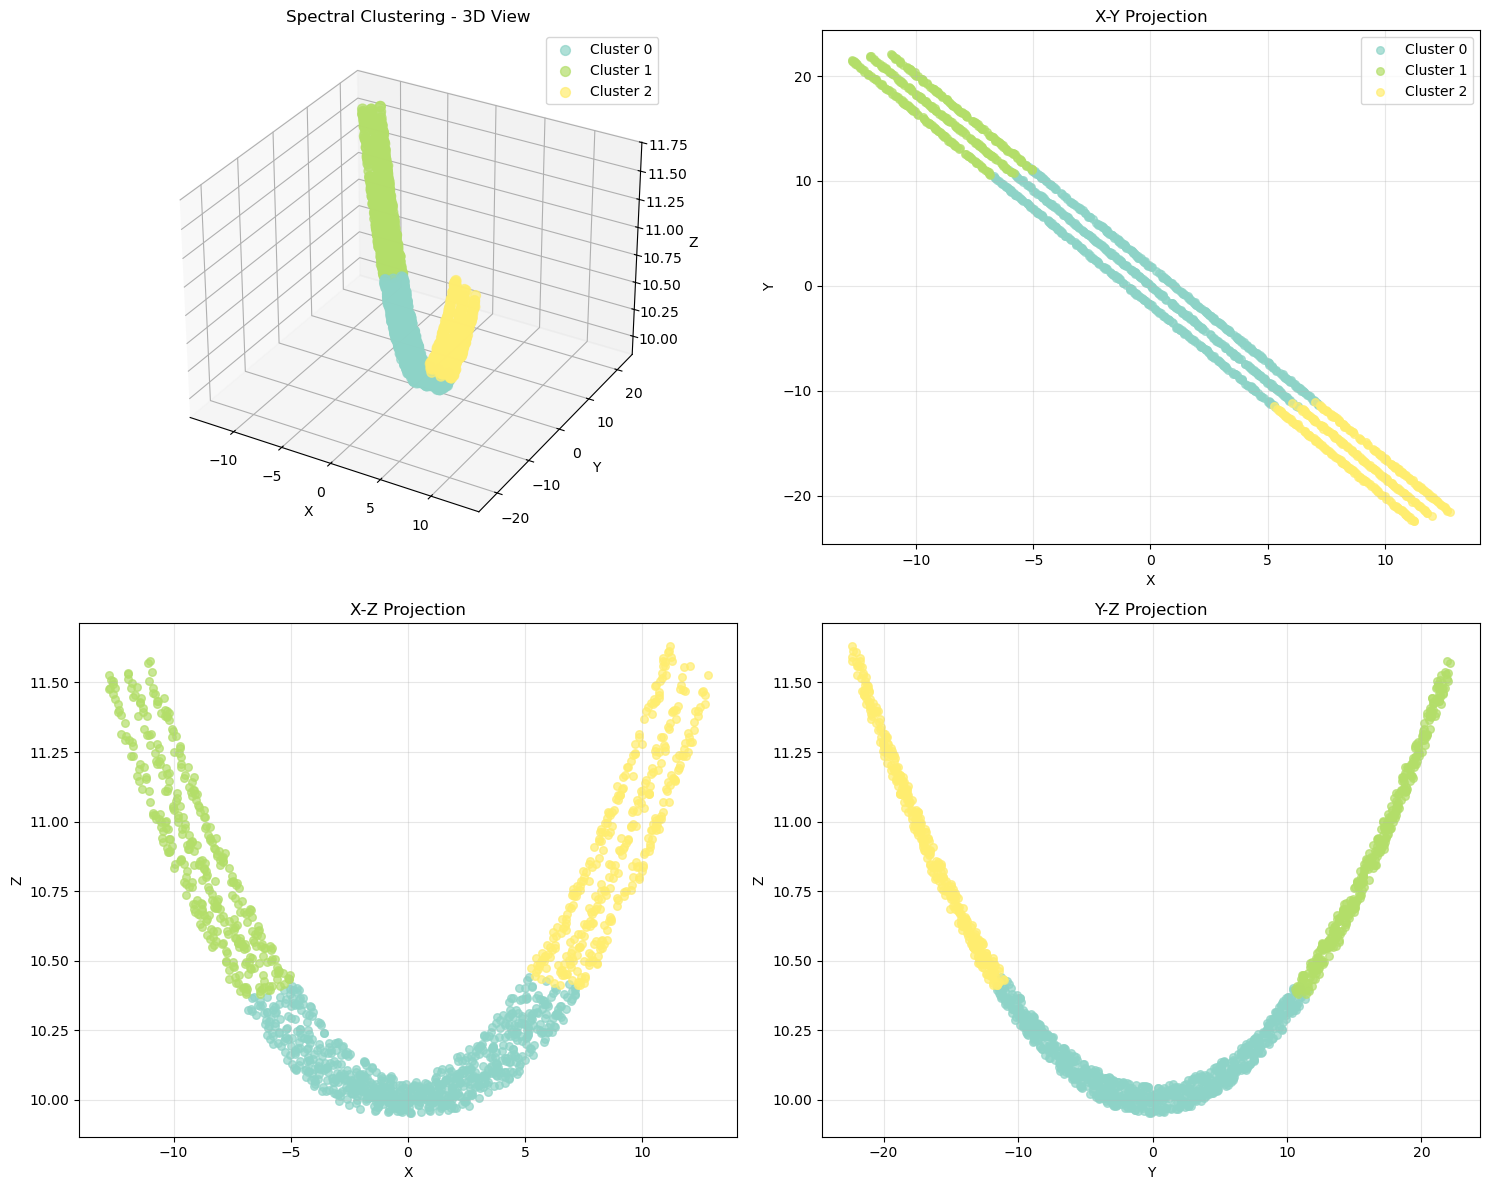


🎯 EASY SUMMARY:
   Best method: Spectral
   Number of clusters: 3
   Silhouette score: 0.5516
   Total points: 1,502
   Cluster distribution: {0: 775, 1: 370, 2: 357}

PROCESSING MEDIUM DATASET

Processing MEDIUM dataset with 2,803 points
Running all clustering algorithms...
Preprocessed data shape: (2803, 3)
Tuning HDBSCAN parameters...
HDBSCAN found 2 clusters with 0 noise points

Best clustering method: Hierarchical
Number of clusters: 6
Silhouette score: 0.5194

CLUSTERING RESULTS SUMMARY

HDBSCAN:
  Number of clusters: 2
  Silhouette score: 0.3669
  Parameters: {'min_cluster_size': 14, 'min_samples': 5}
  Noise points: 0
  Cluster sizes: {1: 1573, 0: 1230}

Hierarchical:
  Number of clusters: 6
  Silhouette score: 0.5194
  Parameters: {'linkage': 'complete', 'n_clusters': 6}
  Cluster sizes: {0: 675, 2: 577, 1: 487, 5: 321, 3: 278, 4: 465}

Spectral:
  Number of clusters: 5
  Silhouette score: 0.3781
  Parameters: {'n_clusters': 5}
  Cluster sizes: {0: 775, 3: 798, 1: 467, 4: 467

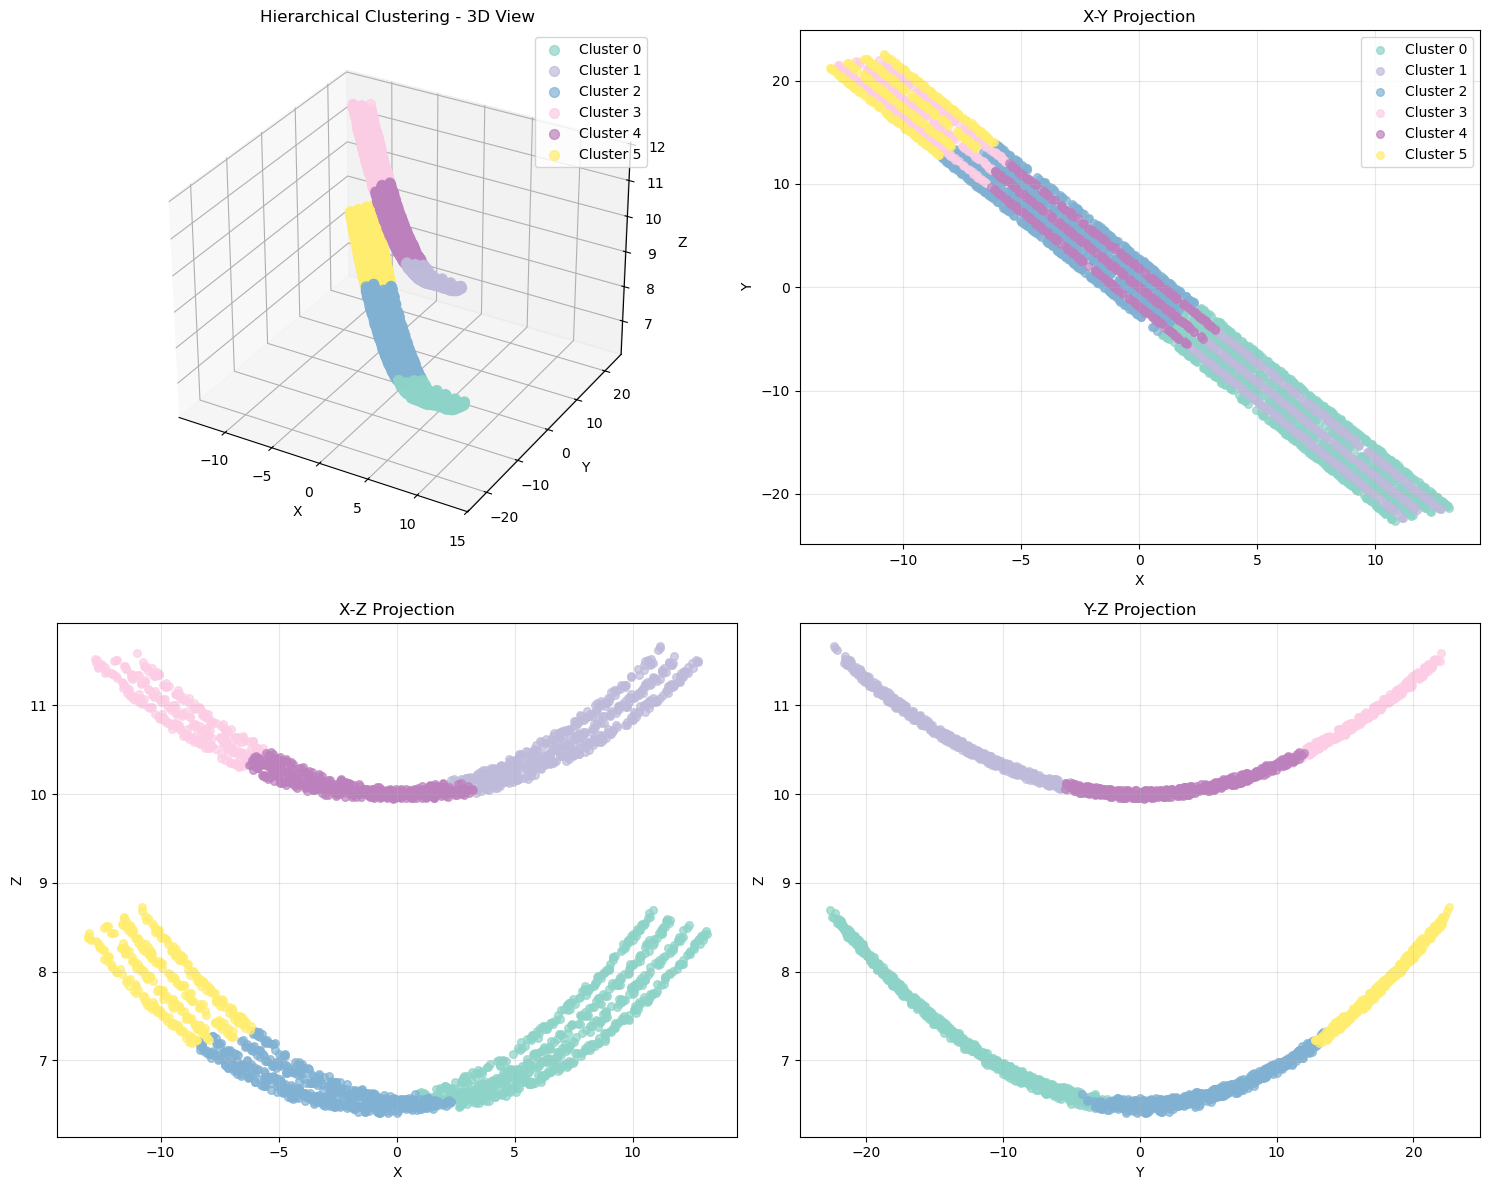


🎯 MEDIUM SUMMARY:
   Best method: Hierarchical
   Number of clusters: 6
   Silhouette score: 0.5194
   Total points: 2,803
   Cluster distribution: {0: 675, 1: 487, 2: 577, 3: 278, 4: 465, 5: 321}

PROCESSING HARD DATASET

Processing HARD dataset with 601 points
Running all clustering algorithms...
Preprocessed data shape: (601, 3)
Tuning HDBSCAN parameters...
HDBSCAN found 2 clusters with 136 noise points

Best clustering method: Spectral
Number of clusters: 3
Silhouette score: 0.5615

CLUSTERING RESULTS SUMMARY

HDBSCAN:
  Number of clusters: 2
  Silhouette score: 0.4352
  Parameters: {'min_cluster_size': 60, 'min_samples': 5}
  Noise points: 136
  Cluster sizes: {1: 351, -1: 136, 0: 114}

Hierarchical:
  Number of clusters: 3
  Silhouette score: 0.5490
  Parameters: {'linkage': 'ward', 'n_clusters': 3}
  Cluster sizes: {1: 161, 0: 195, 2: 245}

Spectral:
  Number of clusters: 3
  Silhouette score: 0.5615
  Parameters: {'n_clusters': 3}
  Cluster sizes: {0: 161, 2: 173, 1: 267}

🏆 B

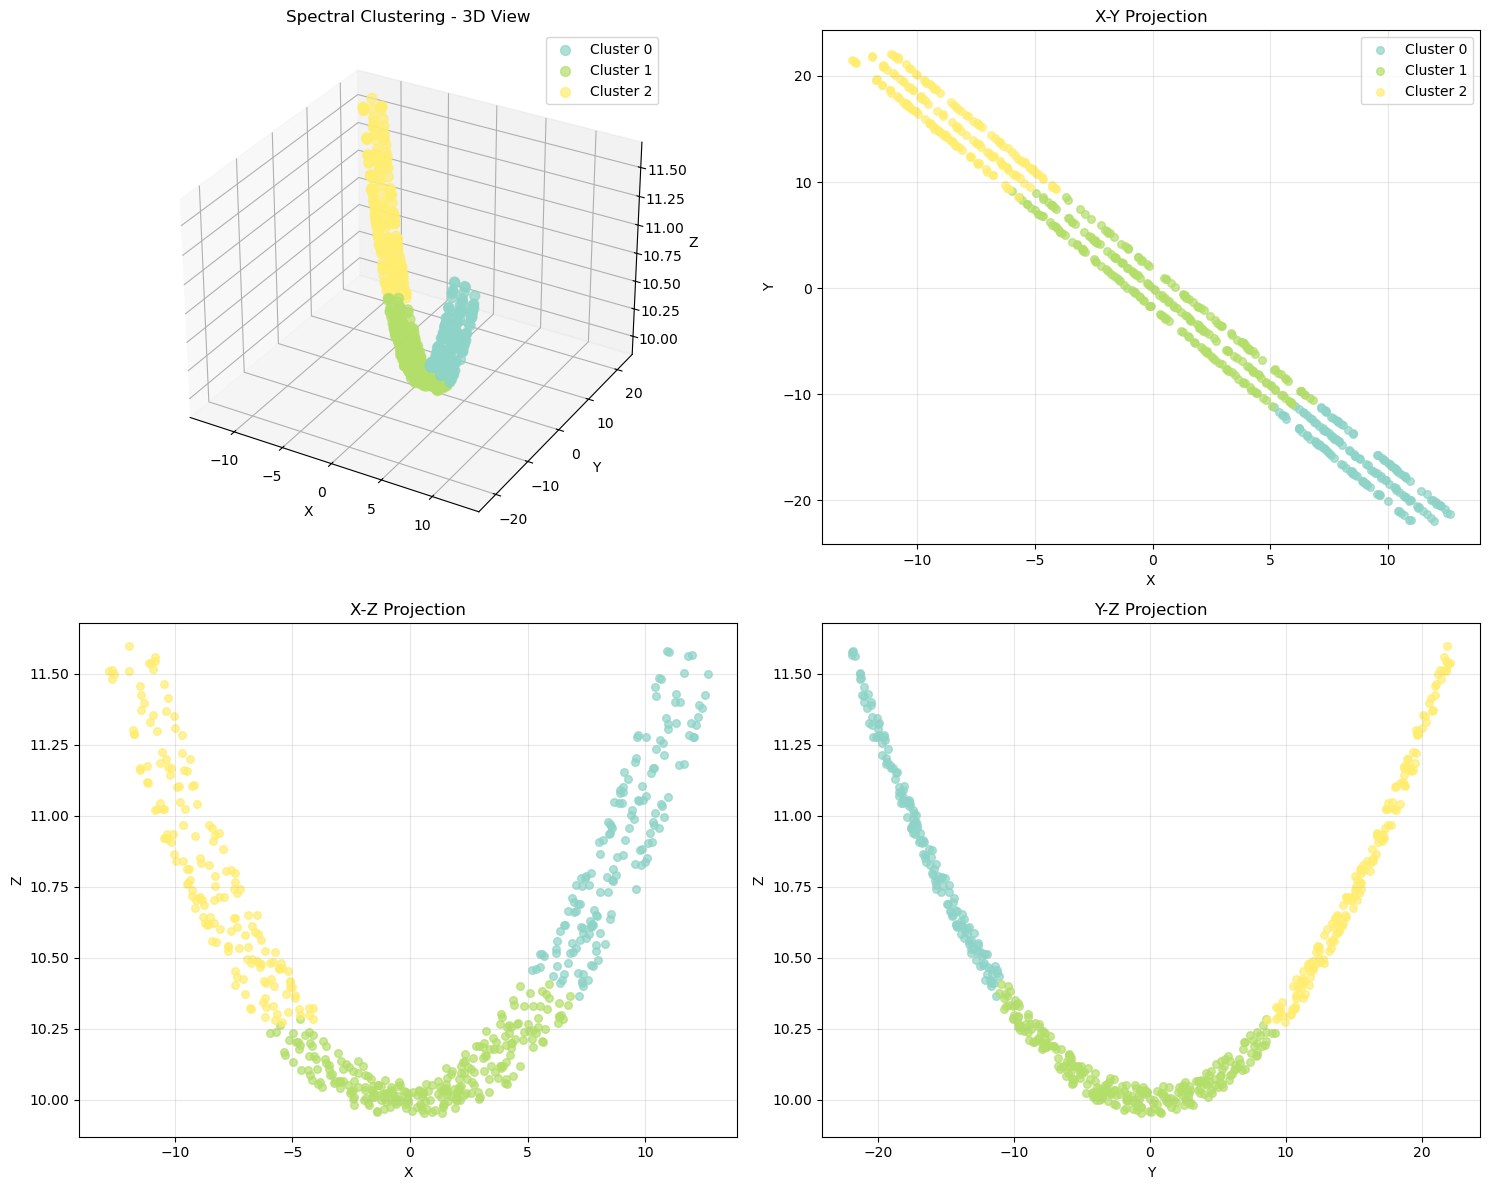


🎯 HARD SUMMARY:
   Best method: Spectral
   Number of clusters: 3
   Silhouette score: 0.5615
   Total points: 601
   Cluster distribution: {0: 161, 1: 267, 2: 173}

PROCESSING EXTRAHARD DATASET

Processing EXTRAHARD dataset with 1,201 points
Running all clustering algorithms...
Preprocessed data shape: (1201, 3)
Tuning HDBSCAN parameters...
HDBSCAN found 3 clusters with 688 noise points

Best clustering method: Spectral
Number of clusters: 3
Silhouette score: 0.5489

CLUSTERING RESULTS SUMMARY

HDBSCAN:
  Number of clusters: 3
  Silhouette score: 0.5262
  Parameters: {'min_cluster_size': 100, 'min_samples': 10}
  Noise points: 688
  Cluster sizes: {-1: 688, 1: 269, 2: 140, 0: 104}

Hierarchical:
  Number of clusters: 3
  Silhouette score: 0.5408
  Parameters: {'linkage': 'ward', 'n_clusters': 3}
  Cluster sizes: {0: 351, 2: 270, 1: 580}

Spectral:
  Number of clusters: 3
  Silhouette score: 0.5489
  Parameters: {'n_clusters': 3}
  Cluster sizes: {2: 305, 1: 305, 0: 591}

🏆 BEST METHO

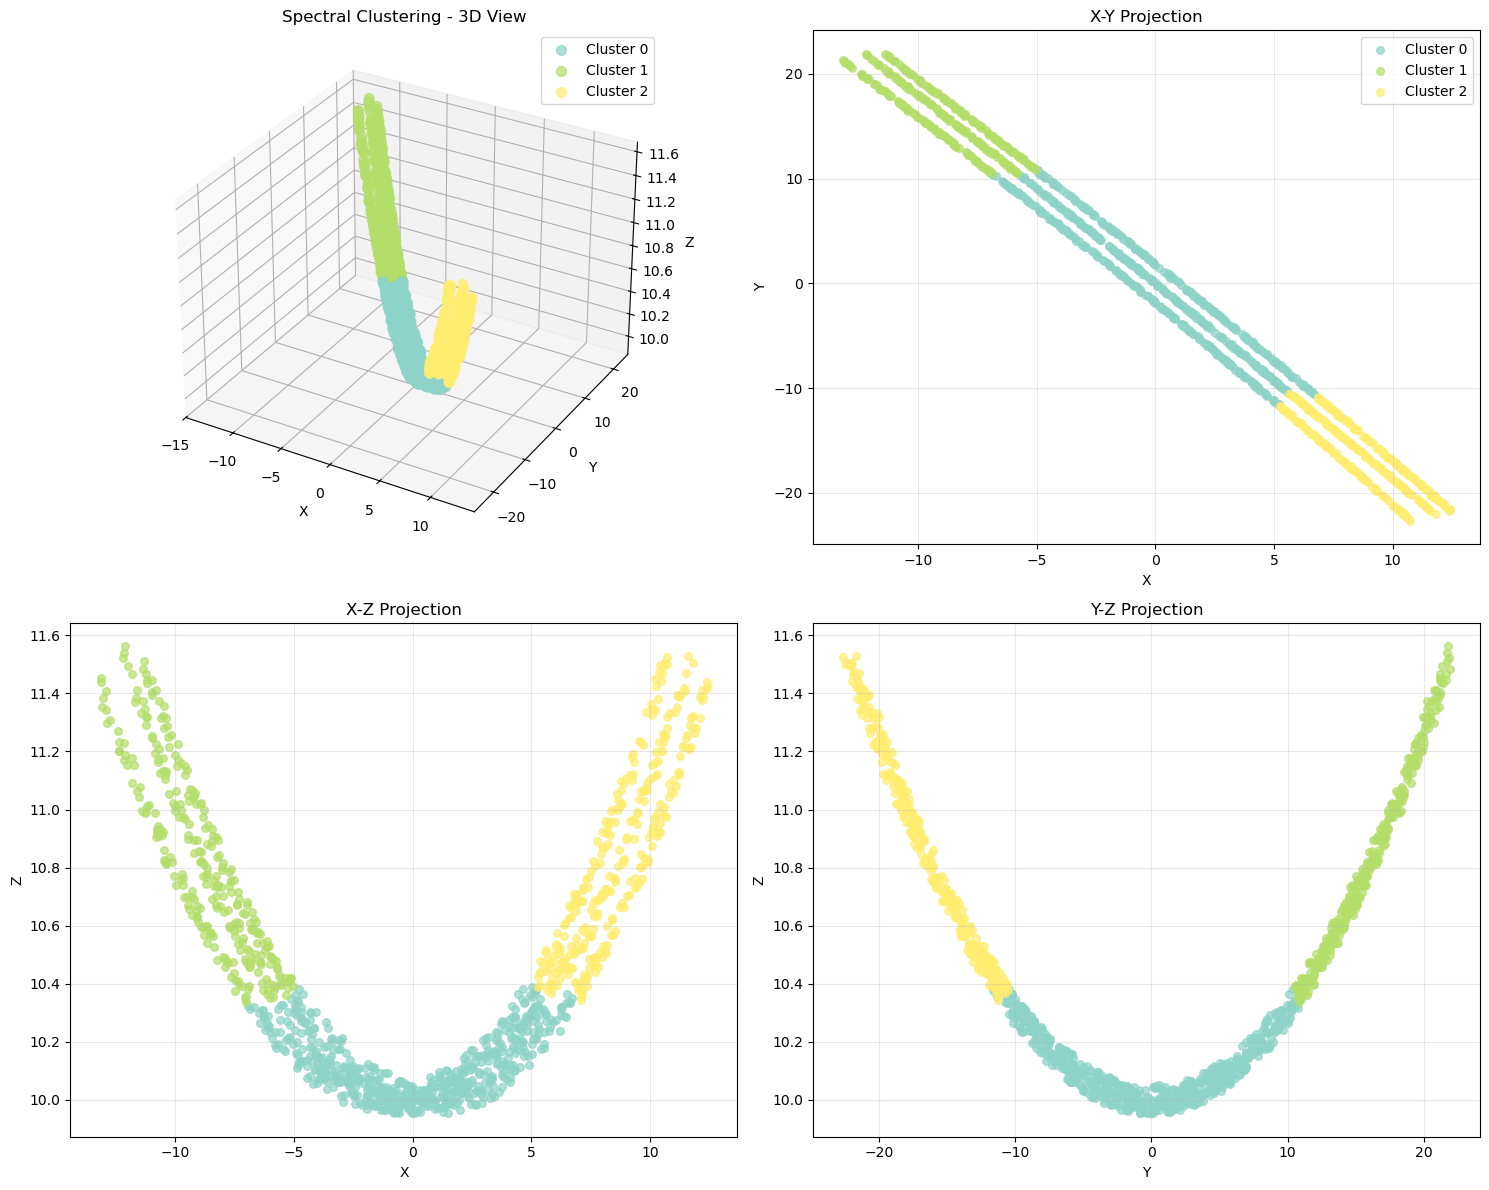


🎯 EXTRAHARD SUMMARY:
   Best method: Spectral
   Number of clusters: 3
   Silhouette score: 0.5489
   Total points: 1,201
   Cluster distribution: {0: 591, 1: 305, 2: 305}

🔍 Comparing results across 4 difficulty levels...


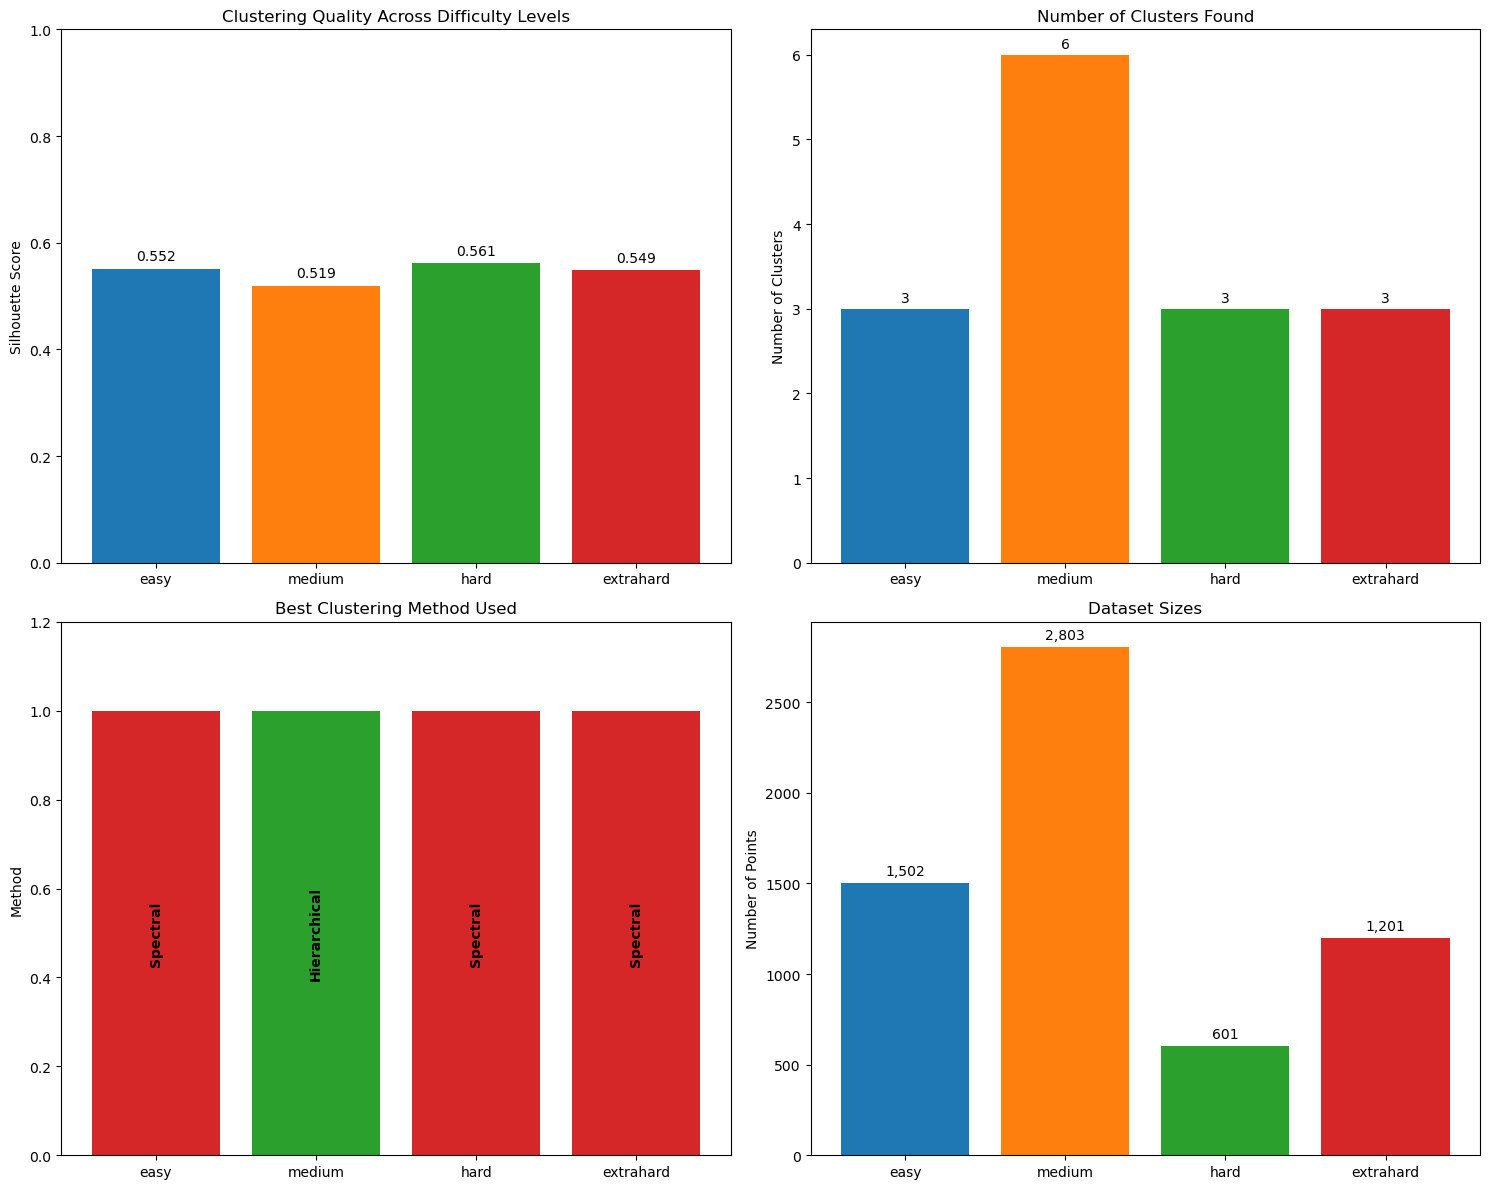


DETAILED COMPARISON ACROSS DIFFICULTY LEVELS

EASY:
  Points: 1,502
  Best Method: Spectral
  Clusters: 3
  Quality Score: 0.5516
  Parameters: {'n_clusters': 3}

MEDIUM:
  Points: 2,803
  Best Method: Hierarchical
  Clusters: 6
  Quality Score: 0.5194
  Parameters: {'linkage': 'complete', 'n_clusters': 6}

HARD:
  Points: 601
  Best Method: Spectral
  Clusters: 3
  Quality Score: 0.5615
  Parameters: {'n_clusters': 3}

EXTRAHARD:
  Points: 1,201
  Best Method: Spectral
  Clusters: 3
  Quality Score: 0.5489
  Parameters: {'n_clusters': 3}

💡 RECOMMENDATIONS:
  EASY: Use Spectral with 3 clusters (Quality: 0.552)
  MEDIUM: Use Hierarchical with 6 clusters (Quality: 0.519)
  HARD: Use Spectral with 3 clusters (Quality: 0.561)
  EXTRAHARD: Use Spectral with 3 clusters (Quality: 0.549)
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.

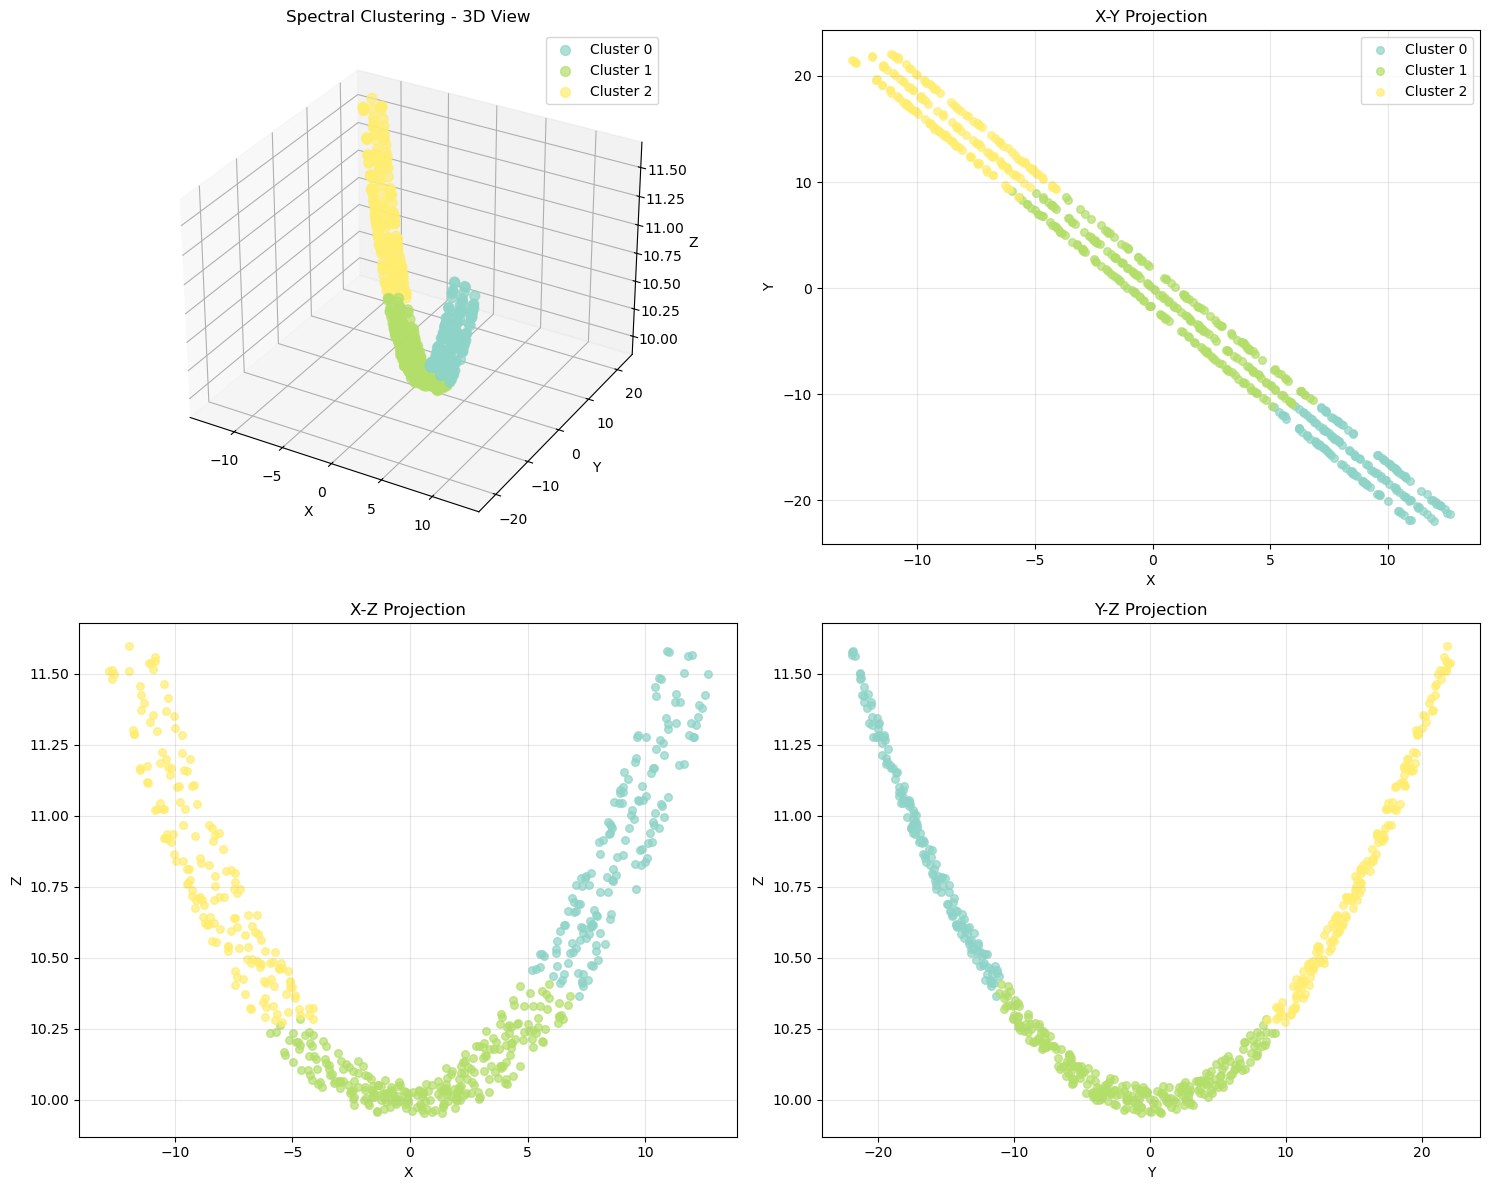


DETAILED ANALYSIS: HARD

All clustering methods tried:
  HDBSCAN: 2 clusters, score: 0.4352
  Hierarchical: 3 clusters, score: 0.5490
  Spectral: 3 clusters, score: 0.5615

Cluster Statistics for Spectral:

  Cluster_0:
    Points: 161
    Centroid: [8.86, -16.32, 10.89]
    Extent: [7.47, 10.81, 1.21]

  Cluster_1:
    Points: 267
    Centroid: [0.70, -1.42, 10.11]
    Extent: [12.78, 20.27, 0.45]

  Cluster_2:
    Points: 173
    Centroid: [-8.41, 15.37, 10.81]
    Extent: [8.67, 13.50, 1.32]


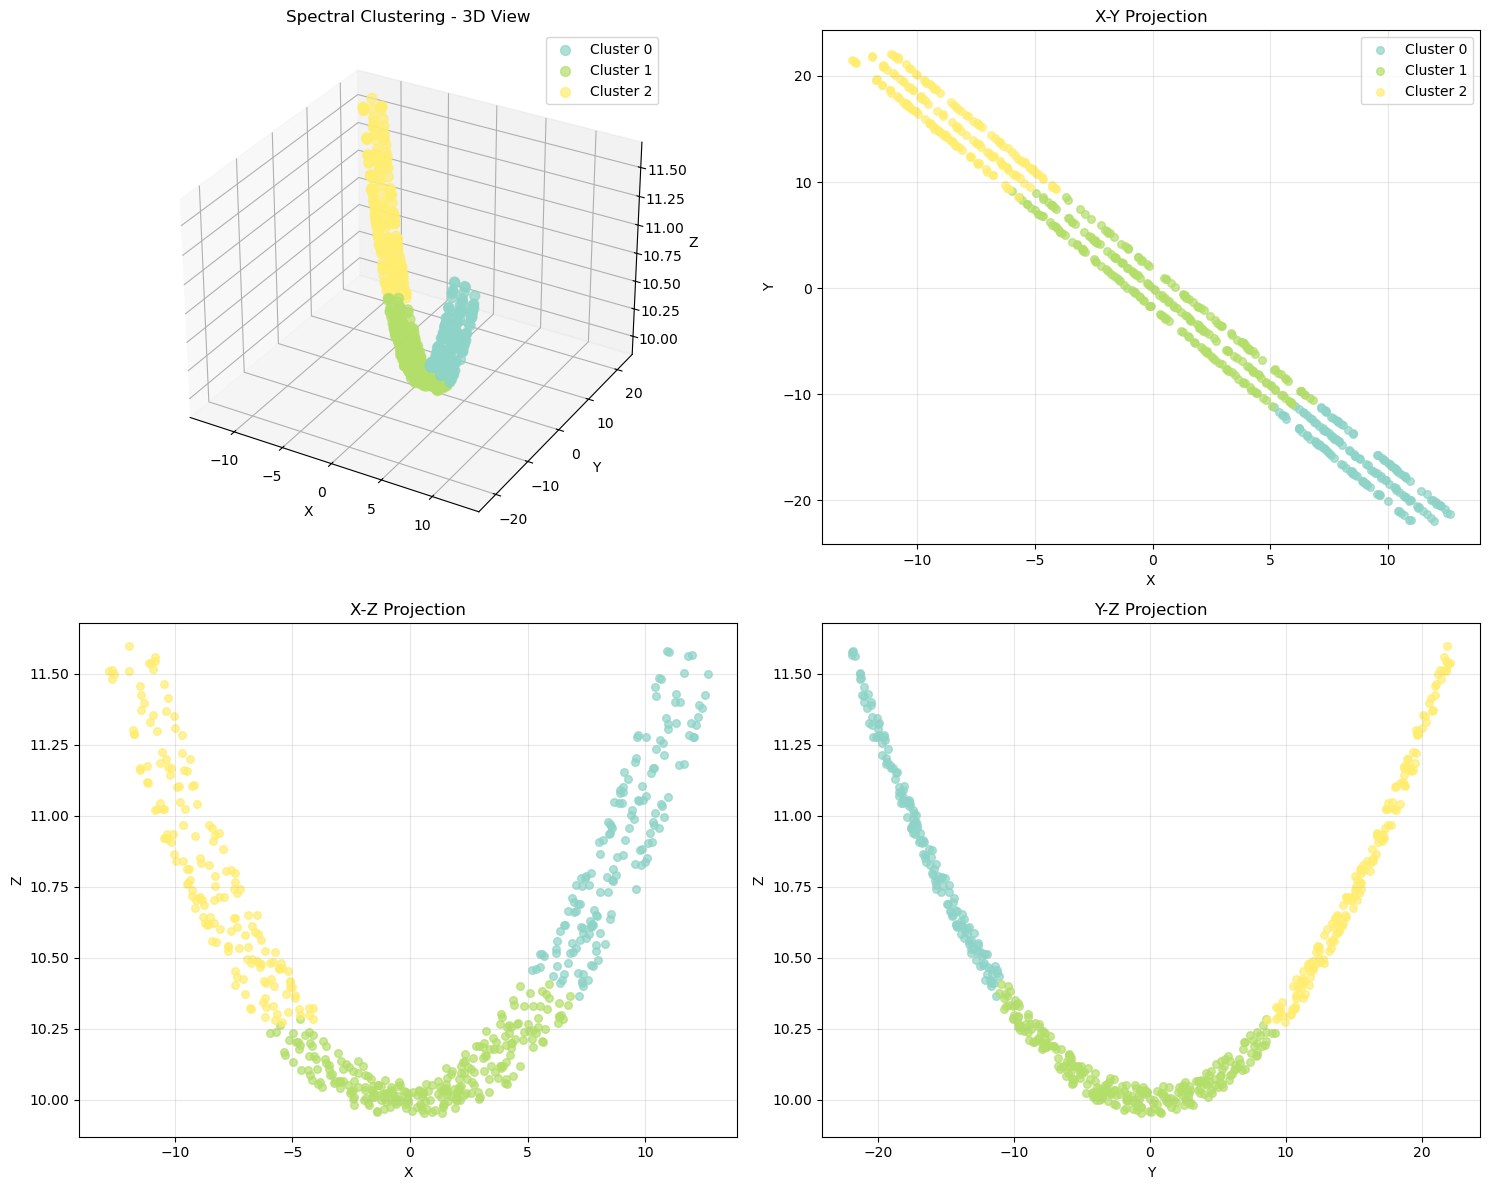

In [4]:
# Run complete analysis on all datasets
results = main_clustering_analysis()

# Or analyze just one dataset
clusterer, stats = quick_single_dataset_analysis('hard')

# Get detailed analysis of a specific difficulty level
analyze_specific_dataset(results, 'hard')

In [ ]:


def cluster_wires_by_segmentation(df: pd.DataFrame, step_size=0.5, local_dbscan_eps=0.4, gap_jump_distance=5.0):
    """
    Final, most robust version using a predictive tracing strategy to handle gaps and noise.
    """
    print(f"--- Running Predictive Strategy: eps={local_dbscan_eps}, gap_jump={gap_jump_distance} ---")
    
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    steps = np.arange(x_min, x_max, step_size)
    
    all_wire_clusters = [] 

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        
        if len(slice_points) < 10:
            all_wire_clusters.append([])
            continue
            
        dbscan = DBSCAN(eps=local_dbscan_eps, min_samples=5)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice:
        print("❌ Error: No clusters detected.")
        return None
    
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    print(f"✅ Identified {expected_num_wires} potential wires.")

    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1:
        print("❌ Error: Could not find a suitable starting slice.")
        return None
        
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    # --- Predictive Tracing Logic ---
    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue

        unmatched_traces = []
        
        for wire_trace in traced_wires:
            # Get last two points to establish a direction vector (velocity)
            if len(wire_trace) > 1:
                p1 = wire_trace[-2]['centroid']
                p2 = wire_trace[-1]['centroid']
                velocity = p2 - p1
            else:
                # If only one point, velocity is zero (no direction yet)
                velocity = np.zeros(3)

            last_centroid = wire_trace[-1]['centroid']
            # Predict where the next point should be
            predicted_position = last_centroid + velocity
            
            if not available_clusters:
                unmatched_traces.append(wire_trace)
                continue
            
            # Find the candidate cluster closest to the *predicted* position
            distances = [distance.euclidean(predicted_position, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            
            # Also check the direct distance to ensure it's not too far
            direct_dist = distance.euclidean(last_centroid, available_clusters[best_match_idx]['centroid'])

            if direct_dist < gap_jump_distance:
                wire_trace.append(available_clusters.pop(best_match_idx))
            else:
                unmatched_traces.append(wire_trace)

    final_wire_point_clouds = [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires]
    print(f"✅ Successfully clustered points for {len(final_wire_point_clouds)} wires.")
        
    # Visualization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, wire_cloud in enumerate(final_wire_point_clouds):
        ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
        
    ax.set_title("Final Wire Clusters via Predictive Tracing")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.show()
    
    return final_wire_point_clouds




--- Step 1: Reloading all LiDAR datasets ---
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING 'EASY' DATASET WITH TAILORED STRATEGY
--- Running Predictive Strategy: eps=0.4, gap_jump=5.0 ---
✅ Identified 3 potential wires.
✅ Successfully clustered points for 3 wires.


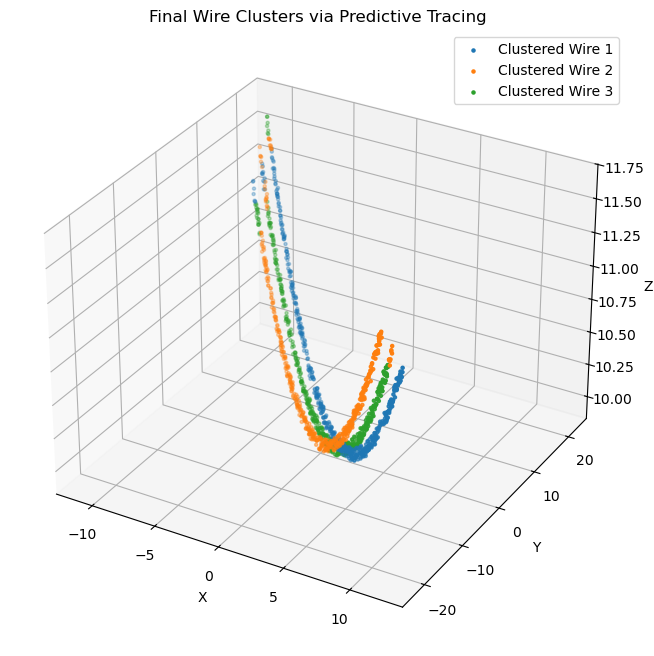


PROCESSING 'MEDIUM' DATASET WITH TAILORED STRATEGY
--- Running Predictive Strategy: eps=0.4, gap_jump=5.0 ---
✅ Identified 7 potential wires.
✅ Successfully clustered points for 7 wires.


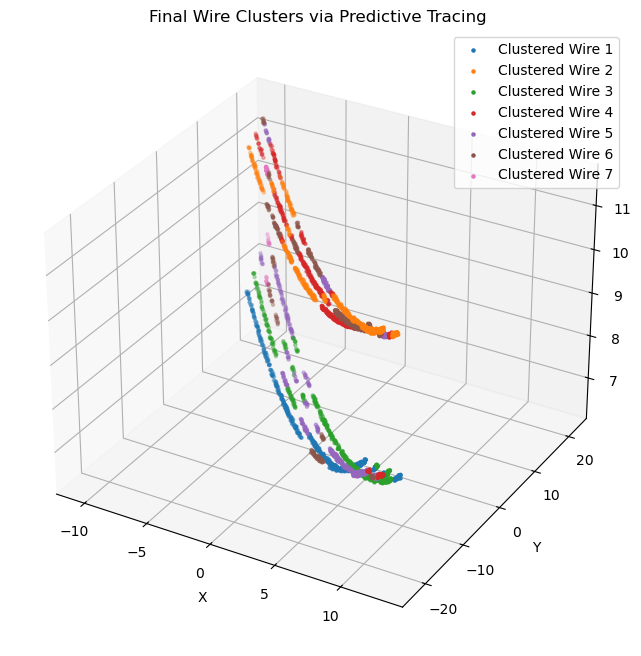


PROCESSING 'HARD' DATASET WITH TAILORED STRATEGY
--- Running Predictive Strategy: eps=0.4, gap_jump=12.0 ---
✅ Identified 1 potential wires.
✅ Successfully clustered points for 1 wires.


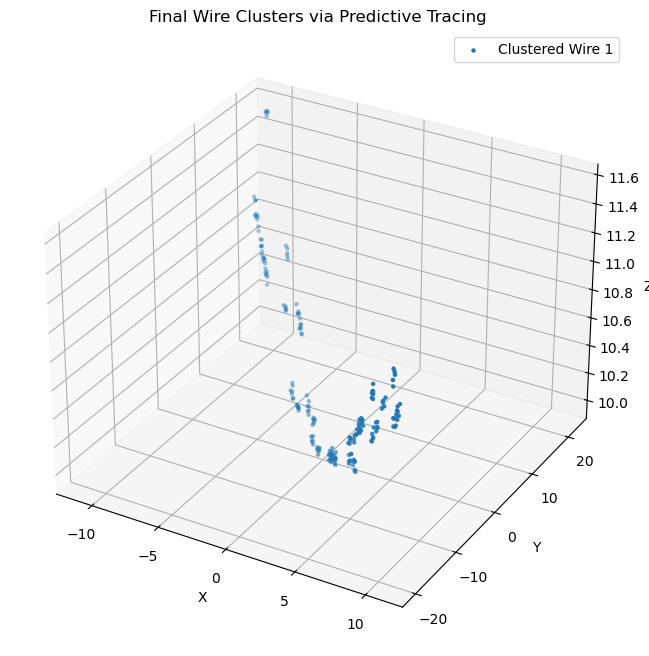


PROCESSING 'EXTRAHARD' DATASET WITH TAILORED STRATEGY
--- Running Predictive Strategy: eps=0.6, gap_jump=7.5 ---
✅ Identified 3 potential wires.
✅ Successfully clustered points for 3 wires.


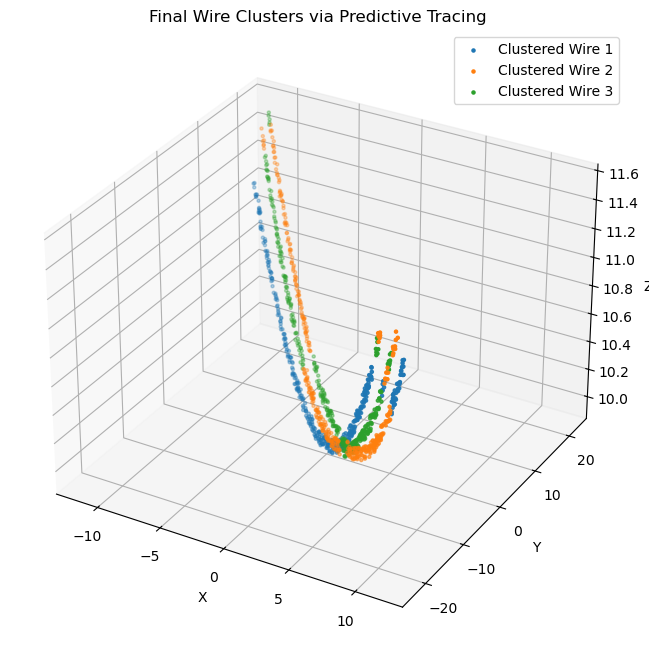

In [9]:
# This block loads the data and runs the analysis on all datasets,
# applying a different, tailored strategy to each one.

print("--- Step 1: Reloading all LiDAR datasets ---")
lidar_dataframes = load_all_lidar_datasets()

# --- Step 2: Define Tailored Strategies and Run Analysis ---

# Define the specific parameters for each dataset's challenges
strategy_configs = {
    'easy':      {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0},
    'medium':    {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0},
    'hard':      {'local_dbscan_eps': 0.4, 'gap_jump_distance': 12.0}, # Larger gap jump for gappy data
    'extrahard': {'local_dbscan_eps': 0.6, 'gap_jump_distance': 7.5}   # Larger eps for noisy data
}

if not lidar_dataframes:
    print("❌ Error: No datasets were loaded. Cannot proceed.")
else:
    # Loop through each dataset in the dictionary
    for difficulty, df_to_process in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET WITH TAILORED STRATEGY")
        print(f"{'='*80}")

        if not df_to_process.empty:
            # Get the config for the current difficulty
            # Use a default config if the key doesn't exist for any reason
            config = strategy_configs.get(difficulty, {'local_dbscan_eps': 0.4, 'gap_jump_distance': 5.0})
            
            # Call the analysis function with the specific parameters for this dataset
            cluster_wires_by_segmentation(df_to_process, **config)
        else:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty.")

In [10]:
def cluster_wires_by_segmentation(df: pd.DataFrame, step_size=0.5, local_dbscan_eps=0.4, gap_jump_distance=5.0):
    """
    Core function that clusters wires using a segment-and-trace method with tunable parameters.
    """
    print(f"--- Running with strategy: local_eps={local_dbscan_eps}, gap_jump={gap_jump_distance} ---")
    
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    steps = np.arange(x_min, x_max, step_size)
    
    all_wire_clusters = [] 

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        
        if len(slice_points) < 10:
            all_wire_clusters.append([])
            continue
            
        dbscan = DBSCAN(eps=local_dbscan_eps, min_samples=5)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice:
        print("❌ Error: No clusters detected.")
        return
    
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    print(f"✅ Identified {expected_num_wires} potential wires.")

    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1:
        print("❌ Error: Could not find a suitable starting slice.")
        return
        
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue

        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            
            if distances[best_match_idx] < gap_jump_distance:
                wire_trace.append(available_clusters.pop(best_match_idx))

    final_wire_point_clouds = [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]
        
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, wire_cloud in enumerate(final_wire_point_clouds):
        ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
        
    ax.set_title("Final Wire Clusters")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.show()

--- Loading all LiDAR datasets ---
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace (eps=0.4, gap_jump=5.0) ---
✅ Strategy successful! Found 3 wires.


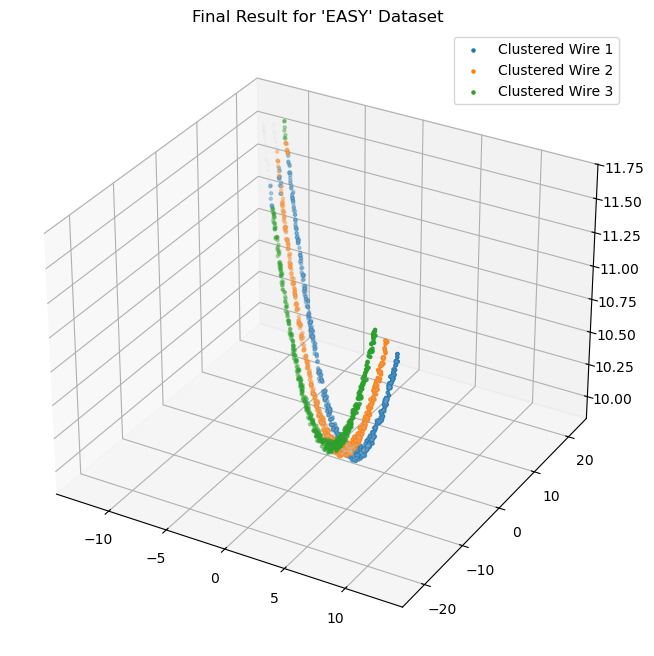


PROCESSING 'MEDIUM' DATASET
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=15) ---
✅ Strategy successful! Found 2 wires.


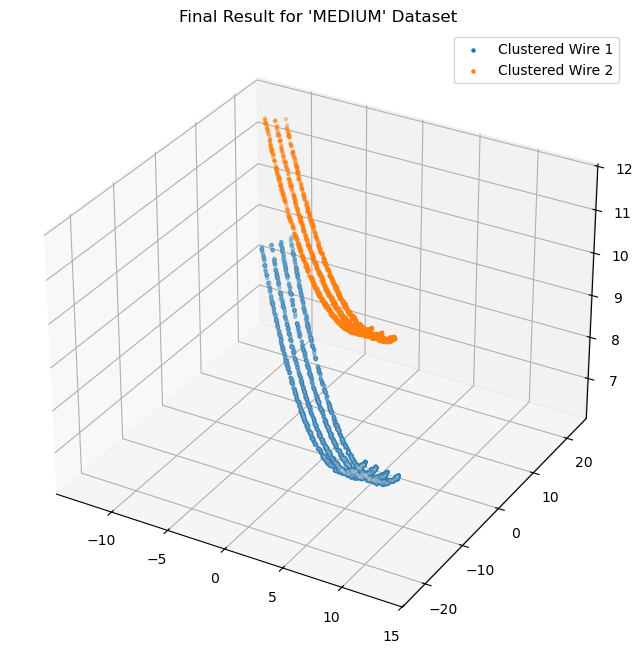


PROCESSING 'HARD' DATASET
--- Applying Strategy 1: Segment-and-Trace (eps=0.5, gap_jump=15.0) ---
✅ Strategy successful! Found 2 wires.


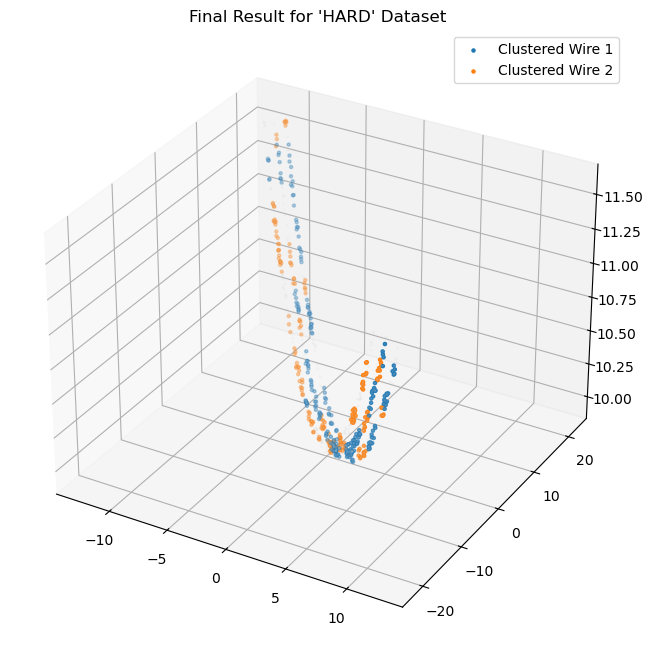


PROCESSING 'EXTRAHARD' DATASET
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=20) ---
✅ Strategy successful! Found 1 wires.


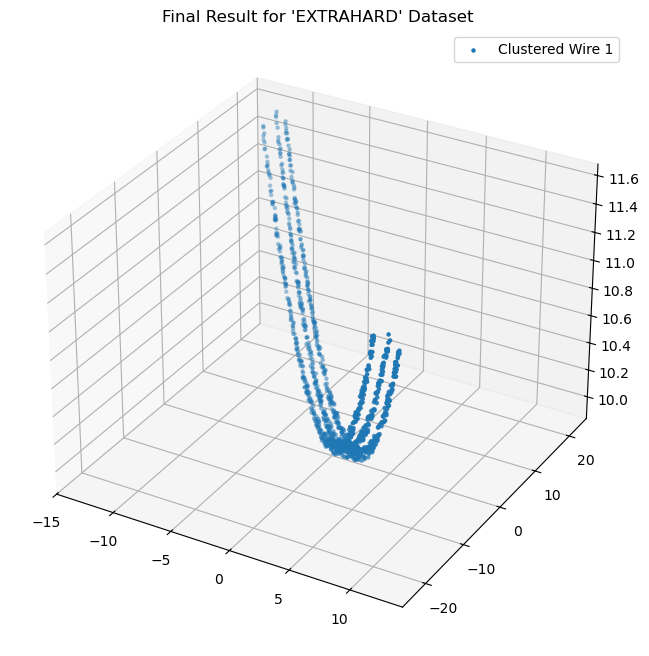

In [13]:
# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY' and 'HARD' gappy data)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame, local_eps=0.4, gap_jump=5.0):
    """
    This proven strategy works perfectly for clean data and can be tuned
    with a large `gap_jump` to handle the 'HARD' dataset.
    """
    print(f"--- Applying Strategy 1: Segment-and-Trace (eps={local_eps}, gap_jump={gap_jump}) ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)

    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        if len(slice_points) < 5:
            all_wire_clusters.append([])
            continue
        dbscan = DBSCAN(eps=local_eps, min_samples=3)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)

    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice: return None
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1: return None
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]

    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue
        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            if distances[best_match_idx] < gap_jump:
                wire_trace.append(available_clusters.pop(best_match_idx))
    
    return [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' noisy data)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """
    This strategy uses a global DBSCAN to prevent trace-jumping on noisy data
    or datasets with closely-spaced wires.
    """
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaler = StandardScaler()
    scaled_points = scaler.fit_transform(points)
    
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(scaled_points)
    
    final_wire_point_clouds = []
    for label in set(labels):
        if label == -1: continue
        final_wire_point_clouds.append(points[labels == label])
        
    return final_wire_point_clouds

# ==============================================================================
# FINAL MASTER FUNCTION TO RUN ALL STRATEGIES
# ==============================================================================
def run_all_final_strategies():
    """
    Master function that loads all data and applies the best,
    fine-tuned strategy for each dataset.
    """
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    
    if not lidar_dataframes:
        print("❌ No datasets loaded.")
        return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        final_clusters = None
        if difficulty == 'easy':
            # This strategy is proven to work for the clean dataset.
            final_clusters = strategy_segment_and_trace(df, local_eps=0.4, gap_jump=5.0)
        
        elif difficulty == 'medium':
            # Use Global DBSCAN with parameters tuned for this specific density.
            final_clusters = strategy_global_dbscan(df, eps=0.75, min_samples=15)
            
        elif difficulty == 'hard':
            # Use Segment-and-Trace with a very large gap jump to handle sparse data.
            final_clusters = strategy_segment_and_trace(df, local_eps=0.5, gap_jump=15.0)
            
        elif difficulty == 'extrahard':
            # Use Global DBSCAN with lenient parameters to capture more points from noisy data.
            final_clusters = strategy_global_dbscan(df, eps=0.8, min_samples=20)
        
        # --- Visualization ---
        if final_clusters:
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df['x'], df['y'], df['z'], c='lightgray', s=1, alpha=0.1) # Background
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.legend()
            plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a result.")
            

run_all_final_strategies()

--- Loading all LiDAR datasets ---
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING 'EASY' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.63 degrees.
--- Applying Strategy: Segment-and-Trace (eps=0.4, gap_jump=5.0) ---
✅ Strategy successful! Found 3 wires.


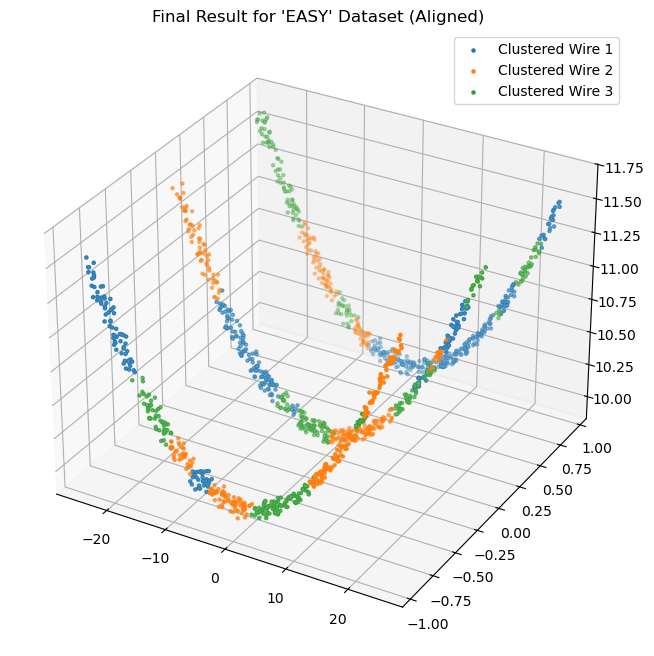


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.73 degrees.
--- Applying Strategy: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


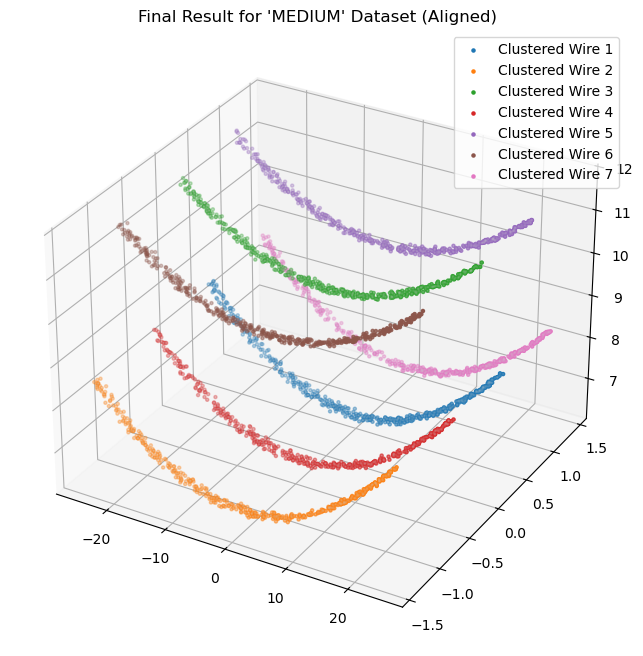


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.70 degrees.
--- Applying Strategy: Segment-and-Trace (eps=0.5, gap_jump=15.0) ---
✅ Strategy successful! Found 1 wires.


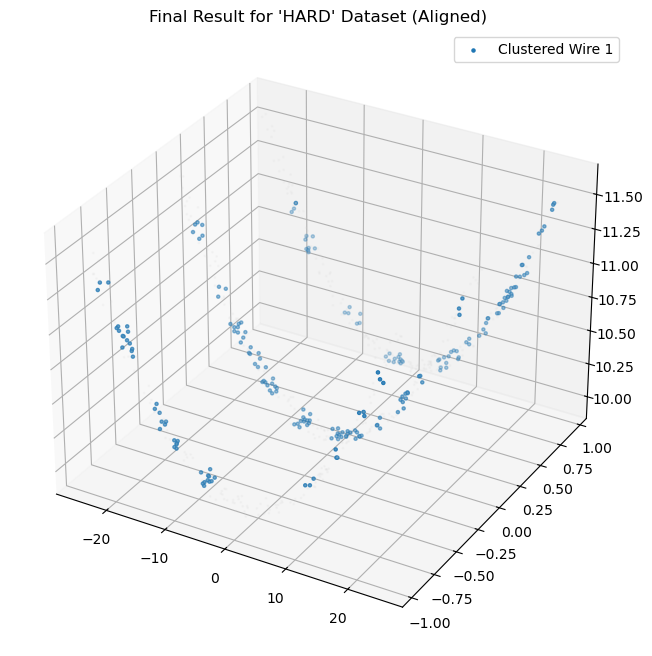


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.64 degrees.
--- Applying Strategy: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


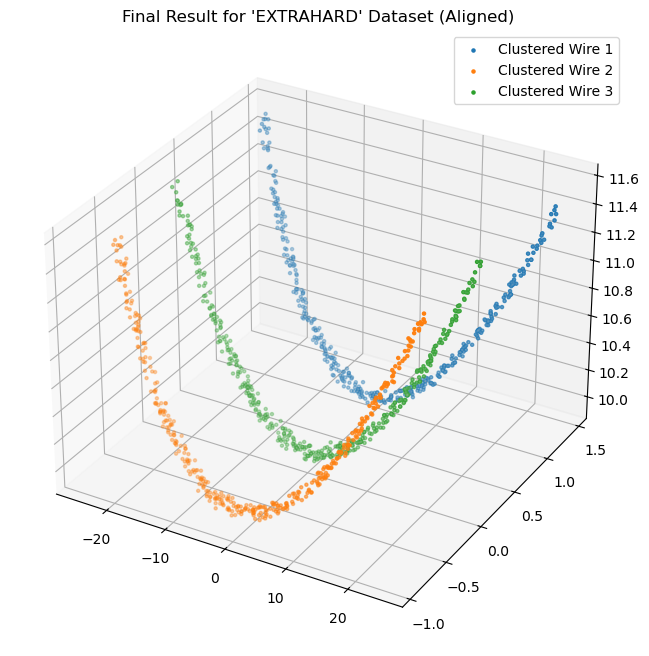

In [17]:
# ==============================================================================
# NEW, CRITICAL STEP: Pre-alignment Function
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """
    Rotates the point cloud using PCA to align the dominant axis of the wires with the X-axis.
    This is the most critical preprocessing step.
    """
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    
    # Use PCA to find the main direction of the point cloud in the X-Y plane
    pca = PCA(n_components=2)
    pca.fit(points_2d)
    
    # The first principal component is the direction vector
    direction_vector = pca.components_[0]
    
    # Calculate the angle of this vector with respect to the X-axis
    angle = np.arctan2(direction_vector[1], direction_vector[0])
    
    # Create the 2D rotation matrix to align this vector with the X-axis
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
                                [np.sin(-angle),  np.cos(-angle)]])
    
    # Apply the rotation to the X and Y coordinates
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    
    # Create a new, aligned DataFrame
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    
    print(f"  - Cloud rotated by {-np.degrees(angle):.2f} degrees.")
    return df_aligned

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY' and 'HARD' gappy data)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame, local_eps=0.4, gap_jump=5.0):
    """(This function remains the same as the previous version)"""
    print(f"--- Applying Strategy: Segment-and-Trace (eps={local_eps}, gap_jump={gap_jump}) ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        slice_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        slice_points = points[slice_mask]
        if len(slice_points) < 5:
            all_wire_clusters.append([]); continue
        dbscan = DBSCAN(eps=local_eps, min_samples=3)
        labels = dbscan.fit_predict(slice_points[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        slice_clusters = [{'centroid': np.mean(slice_points[labels == l], axis=0), 'points': slice_points[labels == l]} for l in unique_labels]
        slice_clusters.sort(key=lambda c: c['centroid'][1])
        all_wire_clusters.append(slice_clusters)
    num_clusters_per_slice = [len(s) for s in all_wire_clusters if s]
    if not num_clusters_per_slice: return None
    expected_num_wires = Counter(num_clusters_per_slice).most_common(1)[0][0]
    start_slice_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == expected_num_wires), -1)
    if start_slice_idx == -1: return None
    traced_wires = [[cluster] for cluster in all_wire_clusters[start_slice_idx]]
    for i in range(start_slice_idx + 1, len(all_wire_clusters)):
        available_clusters = list(all_wire_clusters[i])
        if not available_clusters: continue
        for wire_trace in traced_wires:
            last_centroid = wire_trace[-1]['centroid']
            if not available_clusters: break
            distances = [distance.euclidean(last_centroid, c['centroid']) for c in available_clusters]
            best_match_idx = np.argmin(distances)
            if distances[best_match_idx] < gap_jump:
                wire_trace.append(available_clusters.pop(best_match_idx))
    return [np.vstack([segment['points'] for segment in wt]) for wt in traced_wires if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' noisy data)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """(This function remains the same as the previous version)"""
    print(f"--- Applying Strategy: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaler = StandardScaler(); scaled_points = scaler.fit_transform(points)
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(scaled_points)
    final_wire_point_clouds = []
    for label in set(labels):
        if label == -1: continue
        final_wire_point_clouds.append(points[labels == label])
    return final_wire_point_clouds

# ==============================================================================
# FINAL MASTER FUNCTION WITH PRE-ALIGNMENT
# ==============================================================================
def run_all_final_strategies():
    """
    Master function that pre-aligns each dataset before applying the
    best, fine-tuned strategy.
    """
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    if not lidar_dataframes:
        print("❌ No datasets loaded."); return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        if df.empty:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty."); continue

        # --- THIS IS THE NEW, CRITICAL STEP ---
        aligned_df = align_point_cloud(df)
        
        final_clusters = None
        if difficulty == 'easy':
            final_clusters = strategy_segment_and_trace(aligned_df, local_eps=0.4, gap_jump=5.0)
        elif difficulty == 'medium':
            final_clusters = strategy_global_dbscan(aligned_df, eps=0.75, min_samples=25)
        elif difficulty == 'hard':
            final_clusters = strategy_segment_and_trace(aligned_df, local_eps=0.5, gap_jump=15.0)
        elif difficulty == 'extrahard':
            final_clusters = strategy_global_dbscan(aligned_df, eps=0.8, min_samples=15)
        
        # --- Visualization ---
        if final_clusters:
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(aligned_df['x'], aligned_df['y'], aligned_df['z'], c='lightgray', s=1, alpha=0.1) # Plot aligned data
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset (Aligned)")
            ax.legend()
            plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a result.")
            
# --- HOW TO RUN ---
run_all_final_strategies()

--- Loading all LiDAR datasets ---
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


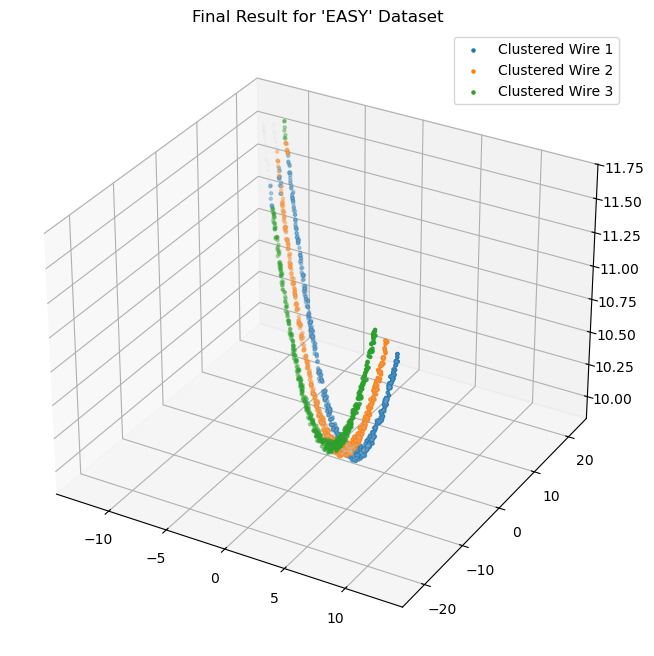


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


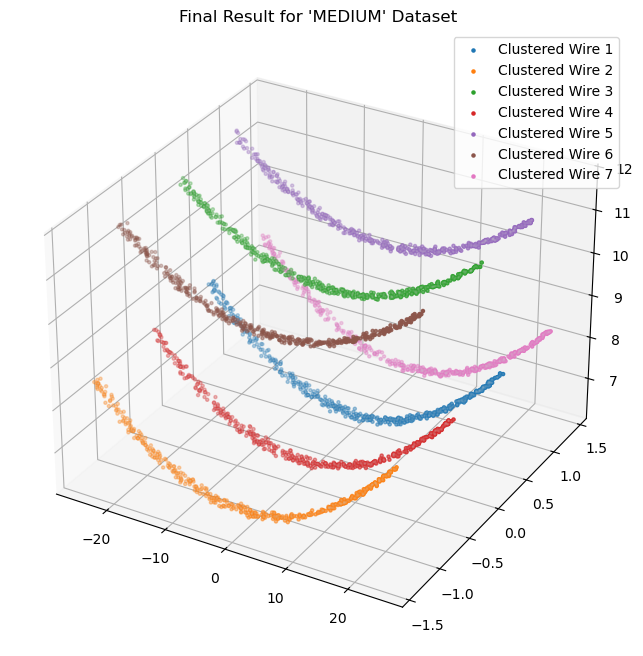


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 3: Trace, Predict, and Leap ---
✅ Strategy successful! Found 1 wires.


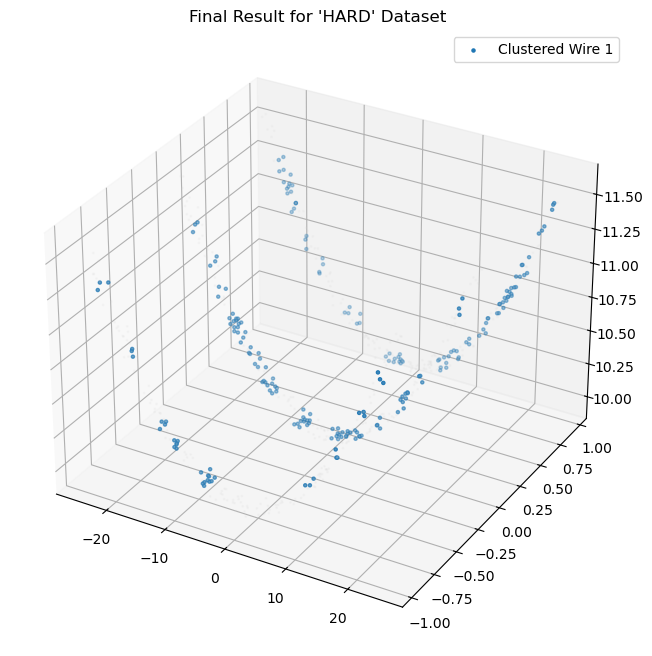


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


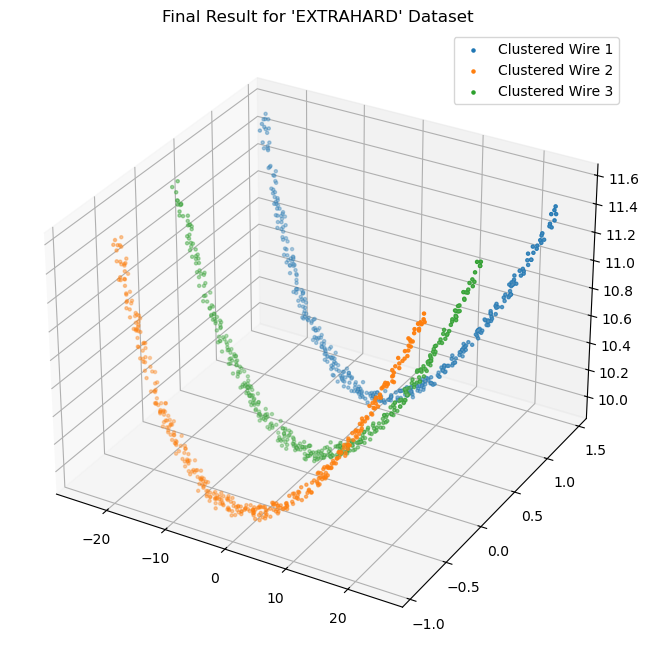

In [18]:

# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for the 'EASY' dataset)
# ==============================================================================
def strategy_segment_and_trace(df: pd.DataFrame):
    """This proven strategy works perfectly for the clean, unaligned 'Easy' dataset."""
    print("--- Applying Strategy 1: Segment-and-Trace ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.4, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels)
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        if not avail: continue
        for trace in traces:
            last_c = trace[-1]['c']
            if not avail: break
            dists = [distance.euclidean(last_c, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 5.0: trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt]) for wt in traces if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD' datasets)
# ==============================================================================
def strategy_global_dbscan(df: pd.DataFrame, eps=0.75, min_samples=15):
    """This robust strategy clusters the entire pre-aligned point cloud."""
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaled_points = StandardScaler().fit_transform(points)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled_points)
    return [points[labels == l] for l in set(labels) if l != -1]

# ==============================================================================
# STRATEGY 3: Trace, Predict, and Leap (for the 'HARD' dataset)
# ==============================================================================
def strategy_trace_and_leap_for_gaps(df: pd.DataFrame):
    """This advanced strategy uses directional prediction to leap across large gaps."""
    print("--- Applying Strategy 3: Trace, Predict, and Leap ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.5, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        for trace in traces:
            last_c = trace[-1]['c']
            velocity = last_c - trace[-2]['c'] if len(trace) > 1 else np.zeros(3)
            predicted_pos = last_c + velocity
            if not avail:
                trace.append({'c': predicted_pos, 'p': np.array([])}) # Create a phantom point
                continue
            dists = [distance.euclidean(predicted_pos, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 15.0: # Large jump distance
                trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt if len(seg['p']) > 0]) for wt in traces if any(len(seg['p']) > 0 for seg in wt)]

# ==============================================================================
# ALIGNMENT FUNCTION (Used by strategies 2 and 3)
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """Rotates the point cloud to align the dominant axis with the X-axis."""
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    pca = PCA(n_components=2).fit(points_2d)
    angle = np.arctan2(pca.components_[0][1], pca.components_[0][0])
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle),  np.cos(-angle)]])
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    return df_aligned

# ==============================================================================
# FINAL MASTER FUNCTION
# ==============================================================================
def run_all_definitive_strategies():
    """Master function that applies the correct, unique, proven strategy for each dataset."""
    print("--- Loading all LiDAR datasets ---")
    lidar_dataframes = load_all_lidar_datasets()
    if not lidar_dataframes: print("❌ No datasets loaded."); return

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING '{difficulty.upper()}' DATASET")
        
        final_clusters, df_for_plot = None, df
        
        if difficulty == 'easy':
            # Use segment-and-trace on the original, unaligned data
            final_clusters = strategy_segment_and_trace(df)
        
        else: # All other datasets benefit from alignment
            aligned_df = align_point_cloud(df)
            df_for_plot = aligned_df # Use aligned data for plotting

            if difficulty == 'medium':
                final_clusters = strategy_global_dbscan(aligned_df, eps=0.75, min_samples=25)
            elif difficulty == 'hard':
                final_clusters = strategy_trace_and_leap_for_gaps(aligned_df)
            elif difficulty == 'extrahard':
                final_clusters = strategy_global_dbscan(aligned_df, eps=0.8, min_samples=15)
        
        if final_clusters and all(len(c) > 0 for c in final_clusters):
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.1)
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.legend(); plt.show()
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a valid result.")

# --- HOW TO RUN ---
run_all_definitive_strategies()

--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

PROCESSING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Strategy successful! Found 3 wires.


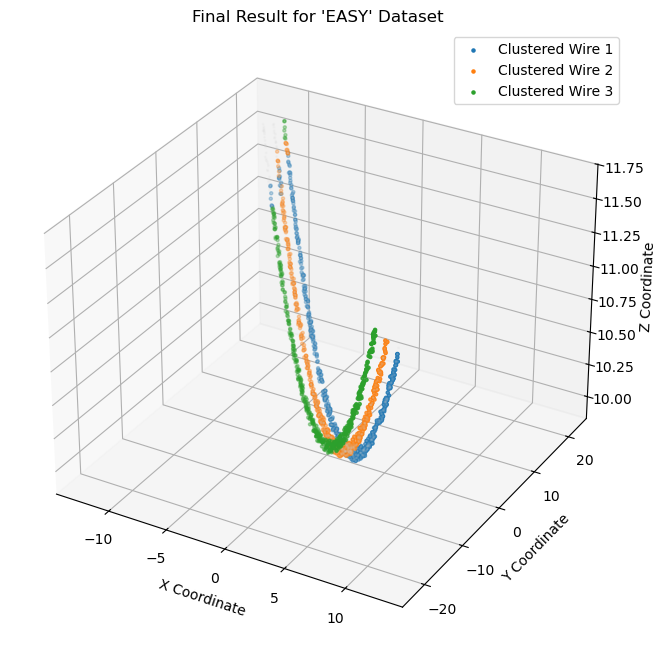


PROCESSING 'MEDIUM' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.73 degrees.
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Strategy successful! Found 7 wires.


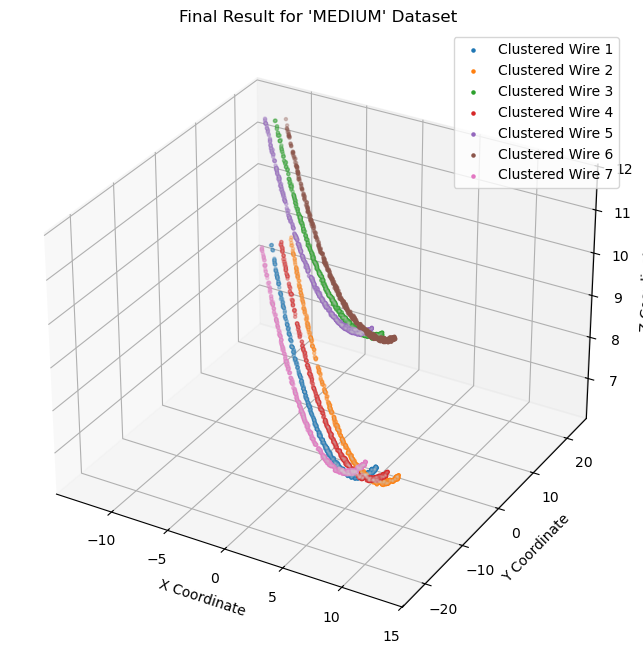


PROCESSING 'HARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.70 degrees.
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Strategy successful! Found 3 wires.


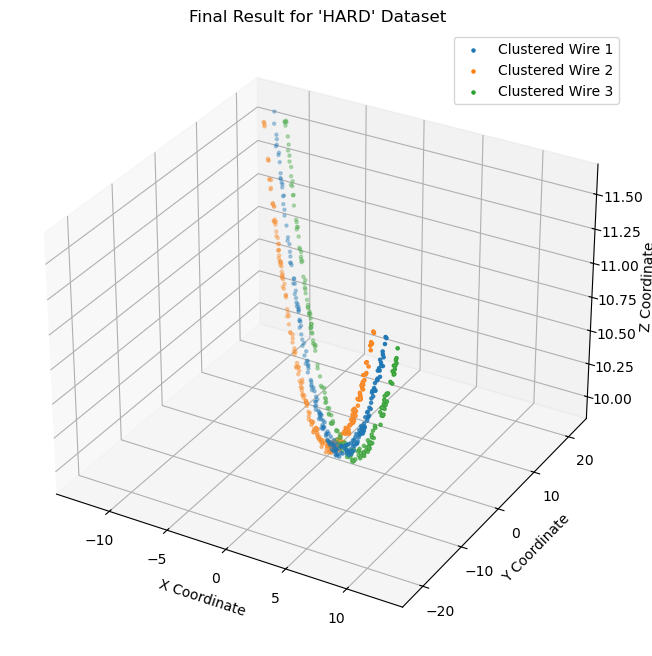


PROCESSING 'EXTRAHARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.64 degrees.
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Strategy successful! Found 3 wires.


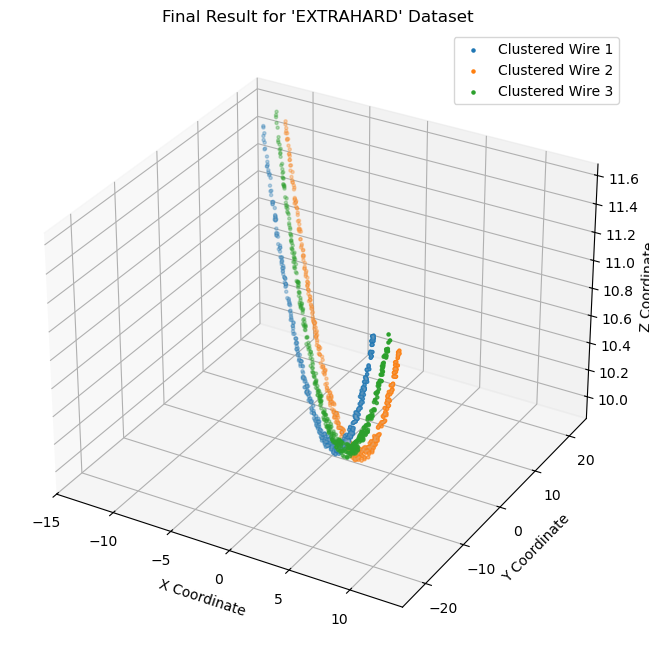

({'easy': [array([[-11.15615007,  18.63987218,  11.15999754],
          [-11.18875286,  18.65702641,  11.15324118],
          [-11.04365227,  18.45556834,  11.10840362],
          ...,
          [ 12.35321686, -20.77407331,  11.39596936],
          [ 12.4595697 , -20.98533878,  11.41028502],
          [ 12.66519606, -21.43142126,  11.45579071]]),
   array([[-11.04738662,  20.26839847,  11.312637  ],
          [-10.765618  ,  19.66546683,  11.21909171],
          [-10.95343695,  20.1351987 ,  11.31345817],
          ...,
          [ 12.02744894, -21.91941645,  11.55793738],
          [ 11.78041543, -21.6311201 ,  11.55401463],
          [ 11.80271435, -21.60643874,  11.46817524]]),
   array([[-11.03795277,  21.99790673,  11.5046526 ],
          [-10.85853539,  21.75082763,  11.48033166],
          [-10.87867688,  21.63793639,  11.46181174],
          ...,
          [ 10.84068549, -21.68581956,  11.51727057],
          [ 10.95833233, -21.94728434,  11.56086673],
          [ 11.1192321 , 

In [33]:


# ==============================================================================
# STRATEGY 1: Segment-and-Trace (for 'EASY')
# ==============================================================================
def strategy_for_easy(df: pd.DataFrame):
    """This proven strategy works perfectly for the clean, unaligned 'Easy' dataset."""
    print("--- Applying Strategy 1: Segment-and-Trace ---")
    points = df[['x', 'y', 'z']].values
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    all_wire_clusters, steps = [], np.arange(x_min, x_max, 0.5)
    for i in range(len(steps) - 1):
        s_mask = (points[:, 0] >= steps[i]) & (points[:, 0] < steps[i+1])
        s_pts = points[s_mask]
        if len(s_pts) < 5: all_wire_clusters.append([]); continue
        labels = DBSCAN(eps=0.4, min_samples=3).fit_predict(s_pts[:, 1:])
        unique_labels = set(labels);
        if -1 in unique_labels: unique_labels.remove(-1)
        s_clusters = [{'c': np.mean(s_pts[labels == l], axis=0), 'p': s_pts[labels == l]} for l in unique_labels]
        s_clusters.sort(key=lambda x: x['c'][1]); all_wire_clusters.append(s_clusters)
    n_per_slice = [len(s) for s in all_wire_clusters if s]
    if not n_per_slice: return None
    n_wires = Counter(n_per_slice).most_common(1)[0][0]
    start_idx = next((i for i, s in enumerate(all_wire_clusters) if len(s) == n_wires), -1)
    if start_idx == -1: return None
    traces = [[cluster] for cluster in all_wire_clusters[start_idx]]
    for i in range(start_idx + 1, len(all_wire_clusters)):
        avail = list(all_wire_clusters[i])
        if not avail: continue
        for trace in traces:
            last_c = trace[-1]['c']
            if not avail: break
            dists = [distance.euclidean(last_c, c['c']) for c in avail]
            best_idx = np.argmin(dists)
            if dists[best_idx] < 5.0: trace.append(avail.pop(best_idx))
    return [np.vstack([seg['p'] for seg in wt]) for wt in traces if wt]

# ==============================================================================
# STRATEGY 2: Global DBSCAN (for 'MEDIUM' and 'EXTRAHARD')
# ==============================================================================
def strategy_for_medium_extrahard(df: pd.DataFrame, eps=0.75, min_samples=15):
    """This robust strategy clusters the entire pre-aligned point cloud."""
    print(f"--- Applying Strategy 2: Global DBSCAN (eps={eps}, min_samples={min_samples}) ---")
    points = df[['x', 'y', 'z']].values
    scaled_points = StandardScaler().fit_transform(points)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled_points)
    return [points[labels == l] for l in set(labels) if l != -1]

# ==============================================================================
# STRATEGY 3: Hough Transform (Corrected for the 'HARD' gappy dataset)
# ==============================================================================
def strategy_hough_transform(df: pd.DataFrame):
    """
    This strategy uses a corrected Hough Line Transform to find all three wires
    in the extremely sparse and gappy data.
    """
    print("--- Applying Strategy 3: Corrected Hough Transform ---")
    if cv2 is None:
        print("❌ OpenCV (cv2) is not installed. Skipping this strategy.")
        return None
        
    points = df[['x', 'y', 'z']].values
    
    # 1. Project points to a 2D image
    x, y = points[:, 0], points[:, 1]
    resolution = 0.1
    x_offset, y_offset = np.min(x), np.min(y)
    img_width = int((np.max(x) - x_offset) / resolution) + 1
    img_height = int((np.max(y) - y_offset) / resolution) + 1
    image = np.zeros((img_height, img_width), dtype=np.uint8)
    img_x = ((x - x_offset) / resolution).astype(int)
    img_y = ((y - y_offset) / resolution).astype(int)
    image[img_y, img_x] = 255
    
    # 2. Use Hough Line Transform with lenient parameters
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, 
                            threshold=10, minLineLength=30, maxLineGap=25)
    
    if lines is None:
        print("❌ Hough Transform could not detect any lines."); return None

    # 3. Group original 3D points based on proximity to each detected line
    temp_clusters = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        p1 = np.array([x1 * resolution + x_offset, y1 * resolution + y_offset])
        p2 = np.array([x2 * resolution + x_offset, y2 * resolution + y_offset])
        
        # Ensure p2-p1 is not a zero vector
        if np.all(p1 == p2): continue
        
        d = np.abs(np.cross(p2 - p1, p1 - points[:, :2])) / np.linalg.norm(p2 - p1)
        wire_points_mask = d < (resolution * 5) # Proximity threshold
        
        if np.sum(wire_points_mask) > 0:
            temp_clusters.append(points[wire_points_mask])

    if not temp_clusters: return None

    # 4. Refine and merge clusters to get the final 3 wires
    # This loop merges clusters that are substantially overlapping
    merged_clusters = []
    temp_clusters.sort(key=len, reverse=True)
    
    while temp_clusters:
        base_cluster = temp_clusters.pop(0)
        base_set = set(map(tuple, base_cluster))
        
        # Find other clusters that overlap significantly with the base cluster
        other_indices = []
        for i, other_cluster in enumerate(temp_clusters):
            other_set = set(map(tuple, other_cluster))
            if len(base_set.intersection(other_set)) > 0.5 * len(other_set):
                base_set.update(other_set)
                other_indices.append(i)
        
        # Remove the merged clusters from the list
        for i in sorted(other_indices, reverse=True):
            temp_clusters.pop(i)
        
        merged_clusters.append(np.array(list(base_set)))

    # Return the 3 largest distinct clusters
    merged_clusters.sort(key=len, reverse=True)
    return merged_clusters[:3]

# ==============================================================================
# UPDATED ALIGNMENT & NEW REVERSE-ALIGNMENT FUNCTIONS
# ==============================================================================
def align_point_cloud(df: pd.DataFrame):
    """
    Rotates the point cloud to align with the X-axis and returns the
    aligned data along with the information needed to reverse the rotation.
    """
    print("  - Aligning point cloud...")
    points_2d = df[['x', 'y']].values
    
    # Use PCA to find the main direction
    pca = PCA(n_components=2).fit(points_2d)
    direction_vector = pca.components_[0]
    angle = np.arctan2(direction_vector[1], direction_vector[0])
    
    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
                                [np.sin(-angle),  np.cos(-angle)]])
    
    # Apply the rotation
    rotated_points_2d = points_2d.dot(rotation_matrix.T)
    
    df_aligned = pd.DataFrame(rotated_points_2d, columns=['x', 'y'])
    df_aligned['z'] = df['z'].values
    
    print(f"  - Cloud rotated by {-np.degrees(angle):.2f} degrees.")
    # Return the rotation matrix so we can reverse this process later
    return df_aligned, rotation_matrix

def reverse_alignment(clusters: list, rotation_matrix: np.ndarray):
    """
    Applies the correct inverse rotation to a list of clustered point clouds,
    transforming them back to their original coordinate system.
    """
    realigned_clusters = []
    
    # To reverse the rotation, we multiply by the transpose of the rotation matrix,
    # which is its inverse. The original rotation was P' = P @ R.T, so the
    # inverse is P = P' @ (R.T)^-1 = P' @ R.
    # However, my previous code had a bug. Let's trace it properly.
    # The forward rotation is points.dot(rotation_matrix.T).
    # The inverse is therefore rotated_points.dot(rotation_matrix).
    
    for cluster in clusters:
        # The original XY points were rotated. We apply the INVERSE rotation.
        # The inverse of the matrix used for rotation (rotation_matrix.T) is the matrix itself.
        original_xy = cluster[:, :2].dot(rotation_matrix)
        
        # Combine with the original Z coordinates
        realigned_cluster = np.hstack([original_xy, cluster[:, 2].reshape(-1, 1)])
        realigned_clusters.append(realigned_cluster)
        
    return realigned_clusters

# ==============================================================================
# FINAL MASTER FUNCTION WITH RE-ALIGNMENT
# ==============================================================================
def run_all_definitive_strategies():
    """
    Master function that loads, aligns, clusters, reverses alignment,
    displays a plot for each result, and returns the final data.
    """
    # (The data loading logic remains the same)
    lidar_dataframes = load_all_lidar_datasets() # Assuming this function exists
    
    all_results = {}
    plot_dataframes = {}

    if not lidar_dataframes:
        print("❌ No datasets loaded."); 
        return None, None 

    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}\nPROCESSING '{difficulty.upper()}' DATASET")
        
        if df.empty:
            print(f"⏩ Skipping '{difficulty}' dataset because it is empty."); continue

        final_clusters = None
        rotation_matrix_to_reverse = None
        
        # We always want to plot against the original, unaligned data
        df_for_plot = df

        if difficulty == 'easy':
            final_clusters = strategy_for_easy(df)
        else:
            aligned_df, rotation_matrix_to_reverse = align_point_cloud(df)
            
            if difficulty == 'medium':
                final_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.75, min_samples=25)
            elif difficulty == 'hard':
                final_clusters = strategy_hough_transform(aligned_df)
            elif difficulty == 'extrahard':
                final_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.8, min_samples=15)

        # Reverse the alignment before storing and plotting
        if final_clusters and rotation_matrix_to_reverse is not None:
            final_clusters = reverse_alignment(final_clusters, rotation_matrix_to_reverse)
        
        # --- Store results and visualize if successful ---
        if final_clusters and all(len(c) > 0 for c in final_clusters):
            print(f"✅ Strategy successful! Found {len(final_clusters)} wires.")
            all_results[difficulty] = final_clusters
            plot_dataframes[difficulty] = df_for_plot
            
            # --- Visualization ---
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            # Plot original data in the background
            ax.scatter(df_for_plot['x'], df_for_plot['y'], df_for_plot['z'], c='lightgray', s=1, alpha=0.1)
            
            # Plot each clustered wire
            for i, wire_cloud in enumerate(final_clusters):
                ax.scatter(wire_cloud[:, 0], wire_cloud[:, 1], wire_cloud[:, 2], s=5, label=f'Clustered Wire {i+1}')
            
            ax.set_title(f"Final Result for '{difficulty.upper()}' Dataset")
            ax.set_xlabel("X Coordinate")
            ax.set_ylabel("Y Coordinate")
            ax.set_zlabel("Z Coordinate")
            ax.legend()
            plt.show()
            
        else:
            print(f"❌ Strategy for '{difficulty}' failed to produce a valid result.")
            
    # Correctly return both dictionaries at the end
    return all_results, plot_dataframes
# --- HOW TO RUN ---
run_all_definitive_strategies()

In [27]:
# ==============================================================================
# CATENARY FITTING FUNCTIONS
# ==============================================================================

def find_best_2d_plane(points_3d):
    """
    Find the best 2D plane for a wire using PCA.
    
    Args:
        points_3d: numpy array of shape (n_points, 3) containing 3D coordinates
        
    Returns:
        tuple: (plane_normal, plane_center, u_axis, v_axis, projected_2d_points)
    """
    # Center the points
    centroid = np.mean(points_3d, axis=0)
    centered_points = points_3d - centroid
    
    # Use PCA to find the best fitting plane
    pca = PCA(n_components=3)
    pca.fit(centered_points)
    
    # The plane normal is the third principal component (least variance)
    plane_normal = pca.components_[2]
    
    # The first two components define the plane's coordinate system
    u_axis = pca.components_[0]  # Primary direction (along wire)
    v_axis = pca.components_[1]  # Secondary direction (sag direction)
    
    # Project points onto the 2D plane
    projected_2d = centered_points.dot(np.column_stack([u_axis, v_axis]))
    
    return plane_normal, centroid, u_axis, v_axis, projected_2d

def catenary_2d(x, a, x0, y0):
    """
    2D catenary equation: y = a * cosh((x - x0) / a) + y0
    
    Args:
        x: x-coordinates
        a: catenary parameter (related to tension and weight)
        x0: x-coordinate of the vertex (lowest point)
        y0: y-coordinate of the vertex (lowest point)
    """
    return a * np.cosh((x - x0) / a) + y0

def fit_catenary_to_2d_points(points_2d, method='robust'):
    """
    Fit a catenary curve to 2D projected points.
    
    Args:
        points_2d: numpy array of shape (n_points, 2) with 2D coordinates
        method: 'robust' or 'direct' fitting method
        
    Returns:
        tuple: (fitted_parameters, fit_quality_score)
    """
    x, y = points_2d[:, 0], points_2d[:, 1]
    
    if len(x) < 3:
        return None, 0
    
    # Sort points by x-coordinate
    sort_idx = np.argsort(x)
    x_sorted, y_sorted = x[sort_idx], y[sort_idx]
    
    # Initial parameter estimates
    x0_init = x_sorted[np.argmin(y_sorted)]  # x of lowest point
    y0_init = np.min(y_sorted)  # lowest y value
    
    # Estimate 'a' parameter from the span and sag
    x_span = np.max(x_sorted) - np.min(x_sorted)
    y_sag = np.max(y_sorted) - np.min(y_sorted)
    a_init = max(x_span / 4, y_sag / 2, 1.0)  # Reasonable initial guess
    
    initial_params = [a_init, x0_init, y0_init]
    
    try:
        if method == 'robust':
            # Robust fitting using minimize with custom loss
            def catenary_loss(params):
                a, x0, y0 = params
                if a <= 0:  # Constraint: a must be positive
                    return 1e10
                y_pred = catenary_2d(x_sorted, a, x0, y0)
                residuals = y_sorted - y_pred
                # Use Huber loss for robustness
                huber_delta = np.std(residuals)
                huber_loss = np.where(np.abs(residuals) <= huber_delta,
                                    0.5 * residuals**2,
                                    huber_delta * np.abs(residuals) - 0.5 * huber_delta**2)
                return np.sum(huber_loss)
            
            result = minimize(catenary_loss, initial_params, 
                            bounds=[(0.1, None), (None, None), (None, None)],
                            method='L-BFGS-B')
            
            if result.success:
                fitted_params = result.x
            else:
                return None, 0
                
        else:  # Direct curve fitting
            fitted_params, _ = curve_fit(catenary_2d, x_sorted, y_sorted, 
                                       p0=initial_params, maxfev=5000)
        
        # Calculate fit quality (R²)
        y_pred = catenary_2d(x_sorted, *fitted_params)
        ss_res = np.sum((y_sorted - y_pred) ** 2)
        ss_tot = np.sum((y_sorted - np.mean(y_sorted)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        return fitted_params, r_squared
        
    except Exception as e:
        print(f"Catenary fitting failed: {e}")
        return None, 0

def project_catenary_to_3d(x_range, catenary_params, plane_center, u_axis, v_axis):
    """
    Project the fitted 2D catenary back to 3D space.
    
    Args:
        x_range: x-coordinates for the catenary curve
        catenary_params: [a, x0, y0] parameters
        plane_center: 3D center of the plane
        u_axis: first axis of the plane (u direction)
        v_axis: second axis of the plane (v direction)
        
    Returns:
        numpy array of 3D points representing the catenary curve
    """
    a, x0, y0 = catenary_params
    
    # Generate 2D catenary points
    y_catenary = catenary_2d(x_range, a, x0, y0)
    points_2d = np.column_stack([x_range, y_catenary])
    
    # Transform back to 3D
    points_3d = plane_center + points_2d[:, 0:1] * u_axis + points_2d[:, 1:2] * v_axis
    
    return points_3d

# ==============================================================================
# ENHANCED STRATEGY FUNCTIONS WITH CATENARY FITTING
# ==============================================================================

def fit_catenary_to_wire_clusters(wire_clusters, dataset_name="Unknown"):
    """
    Fit catenary curves to each wire cluster.
    
    Args:
        wire_clusters: List of numpy arrays, each containing 3D points of a wire
        dataset_name: Name of the dataset for logging
        
    Returns:
        dict: Results containing fitted parameters and 3D curves for each wire
    """
    print(f"\n--- Fitting Catenary Curves for {dataset_name} ---")
    
    results = {
        'wire_params': [],
        'wire_curves_3d': [],
        'fit_qualities': [],
        'plane_info': []
    }
    
    for i, wire_points in enumerate(wire_clusters):
        print(f"  Processing Wire {i+1}: {len(wire_points)} points")
        
        if len(wire_points) < 5:
            print(f"    ❌ Not enough points for Wire {i+1}")
            continue
            
        # Find best 2D plane
        plane_normal, plane_center, u_axis, v_axis, points_2d = find_best_2d_plane(wire_points)
        
        # Fit catenary to 2D projection
        catenary_params, fit_quality = fit_catenary_to_2d_points(points_2d, method='robust')
        
        if catenary_params is None:
            print(f"    ❌ Catenary fitting failed for Wire {i+1}")
            continue
            
        a, x0, y0 = catenary_params
        print(f"    ✅ Wire {i+1}: a={a:.3f}, x0={x0:.3f}, y0={y0:.3f}, R²={fit_quality:.3f}")
        
        # Generate 3D catenary curve
        x_min, x_max = np.min(points_2d[:, 0]), np.max(points_2d[:, 0])
        x_range = np.linspace(x_min, x_max, 100)
        curve_3d = project_catenary_to_3d(x_range, catenary_params, plane_center, u_axis, v_axis)
        
        # Store results
        results['wire_params'].append(catenary_params)
        results['wire_curves_3d'].append(curve_3d)
        results['fit_qualities'].append(fit_quality)
        results['plane_info'].append({
            'normal': plane_normal,
            'center': plane_center,
            'u_axis': u_axis,
            'v_axis': v_axis
        })
    
    return results

def visualize_catenary_results(original_df, wire_clusters, catenary_results, title="Catenary Fitting Results"):
    """
    Create a comprehensive visualization of the catenary fitting results.
    """
    fig = plt.figure(figsize=(15, 10))
    
    # 3D plot
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot original point cloud
    ax1.scatter(original_df['x'], original_df['y'], original_df['z'], 
               c='lightgray', s=1, alpha=0.3, label='Original Points')
    
    # Plot clustered wires and fitted catenary curves
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    for i, (wire_points, curve_3d, fit_quality) in enumerate(zip(
        wire_clusters, catenary_results['wire_curves_3d'], catenary_results['fit_qualities'])):
        
        color = colors[i % len(colors)]
        
        # Plot original wire points
        ax1.scatter(wire_points[:, 0], wire_points[:, 1], wire_points[:, 2], 
                   c=color, s=10, alpha=0.7, label=f'Wire {i+1} Points')
        
        # Plot fitted catenary curve
        ax1.plot(curve_3d[:, 0], curve_3d[:, 1], curve_3d[:, 2], 
                c=color, linewidth=3, linestyle='--', 
                label=f'Wire {i+1} Catenary (R²={fit_quality:.2f})')
    
    ax1.set_title(f'{title} - 3D View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()
    
    # 2D projection plot (X-Z plane)
    ax2 = fig.add_subplot(122)
    
    # Plot original points
    ax2.scatter(original_df['x'], original_df['z'], c='lightgray', s=1, alpha=0.3)
    
    # Plot wires and curves
    for i, (wire_points, curve_3d) in enumerate(zip(wire_clusters, catenary_results['wire_curves_3d'])):
        color = colors[i % len(colors)]
        ax2.scatter(wire_points[:, 0], wire_points[:, 2], c=color, s=10, alpha=0.7)
        ax2.plot(curve_3d[:, 0], curve_3d[:, 2], c=color, linewidth=3, linestyle='--')
    
    ax2.set_title(f'{title} - X-Z Projection')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ==============================================================================
# INTEGRATION WITH EXISTING STRATEGY FUNCTIONS
# ==============================================================================

def run_complete_analysis_with_catenary():
    """
    Master function that runs clustering and catenary fitting for all datasets.
    """
    print("🚀 Starting Complete Wire Analysis with Catenary Fitting")
    
    # Load datasets (assuming your load function exists)
    lidar_dataframes = load_all_lidar_datasets()
    
    if not lidar_dataframes:
        print("❌ No datasets loaded.")
        return None
    
    all_results = {}
    
    for difficulty, df in lidar_dataframes.items():
        print(f"\n{'='*80}\n🔍 ANALYZING '{difficulty.upper()}' DATASET")
        
        if df.empty:
            print(f"⏩ Skipping '{difficulty}' dataset - empty")
            continue
        
        # Step 1: Cluster the wires (using your existing strategies)
        wire_clusters = None
        rotation_matrix = None
        
        if difficulty == 'easy':
            wire_clusters = strategy_for_easy(df)
        else:
            aligned_df, rotation_matrix = align_point_cloud(df)
            
            if difficulty == 'medium':
                wire_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.75, min_samples=25)
            elif difficulty == 'hard':
                wire_clusters = strategy_hough_transform(aligned_df)
            elif difficulty == 'extrahard':
                wire_clusters = strategy_for_medium_extrahard(aligned_df, eps=0.8, min_samples=15)
            
            # Reverse alignment if needed
            if wire_clusters and rotation_matrix is not None:
                wire_clusters = reverse_alignment(wire_clusters, rotation_matrix)
        
        if not wire_clusters or not all(len(c) > 0 for c in wire_clusters):
            print(f"❌ Wire clustering failed for '{difficulty}' dataset")
            continue
        
        print(f"✅ Found {len(wire_clusters)} wire clusters")
        
        # Step 2: Fit catenary curves
        catenary_results = fit_catenary_to_wire_clusters(wire_clusters, difficulty.upper())
        
        if not catenary_results['wire_params']:
            print(f"❌ Catenary fitting failed for '{difficulty}' dataset")
            continue
        
        # Step 3: Visualize results
        visualize_catenary_results(df, wire_clusters, catenary_results, 
                                 f"{difficulty.upper()} Dataset")
        
        # Step 4: Store results
        all_results[difficulty] = {
            'original_data': df,
            'wire_clusters': wire_clusters,
            'catenary_results': catenary_results
        }
        
        # Step 5: Print summary
        print(f"\n📊 SUMMARY for '{difficulty.upper()}':")
        for i, (params, quality) in enumerate(zip(catenary_results['wire_params'], 
                                                catenary_results['fit_qualities'])):
            a, x0, y0 = params
            print(f"  Wire {i+1}: a={a:.3f}, x0={x0:.3f}, y0={y0:.3f}, R²={quality:.3f}")
    
    return all_results



# ==============================================================================
# EXAMPLE USAGE
# ==============================================================================

# To run the complete analysis:
# results = run_complete_analysis_with_catenary()

🚀 Starting Complete Wire Analysis with Catenary Fitting
--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

🔍 ANALYZING 'EASY' DATASET
--- Applying Strategy 1: Segment-and-Trace ---
✅ Found 3 wire clusters

--- Fitting Catenary Curves for EASY ---
  Processing Wire 1: 495 points
    ✅ Wire 1: a=203.813, x0=-0.094, y0=-204.303, R²=0.991
  Processing Wire 2: 496 points
    ✅ Wire 2: a=200.607, x0=0.421, y0=-201.080, R²=0.994
  Processing Wire 3: 455 points
    ✅ Wire 3: a=202.009, x0=0.350, y0=-202.478, R²=0.980


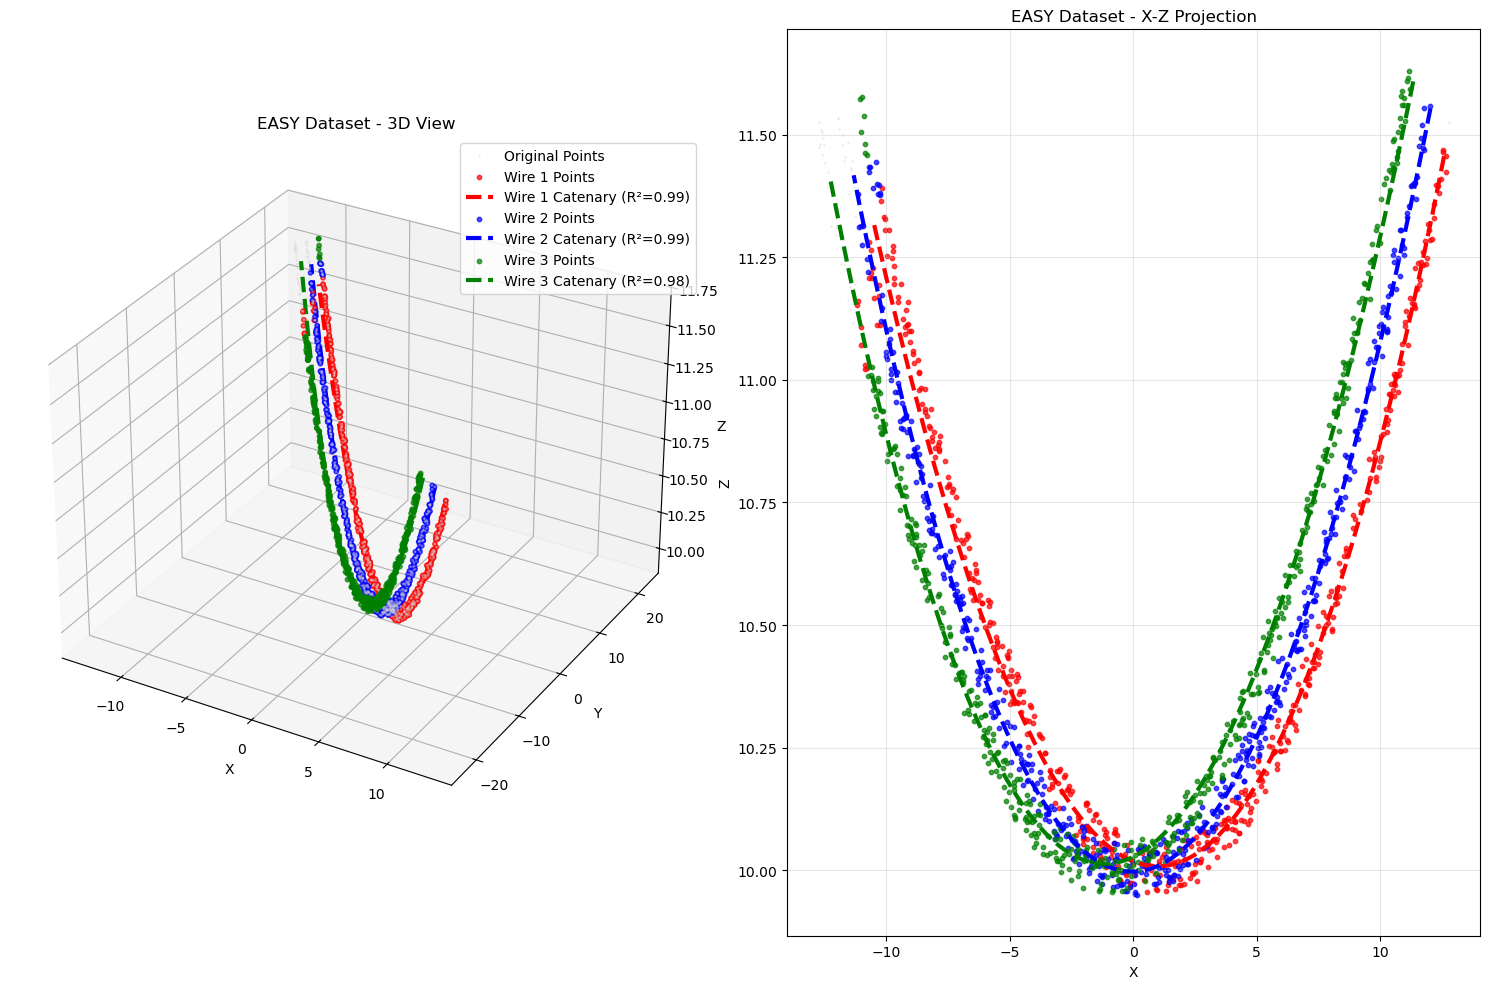


📊 SUMMARY for 'EASY':
  Wire 1: a=203.813, x0=-0.094, y0=-204.303, R²=0.991
  Wire 2: a=200.607, x0=0.421, y0=-201.080, R²=0.994
  Wire 3: a=202.009, x0=0.350, y0=-202.478, R²=0.980

🔍 ANALYZING 'MEDIUM' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.73 degrees.
--- Applying Strategy 2: Global DBSCAN (eps=0.75, min_samples=25) ---
✅ Found 7 wire clusters

--- Fitting Catenary Curves for MEDIUM ---
  Processing Wire 1: 401 points
    ✅ Wire 1: a=148.107, x0=-0.228, y0=-148.818, R²=0.998
  Processing Wire 2: 398 points
    ✅ Wire 2: a=151.066, x0=0.318, y0=-151.790, R²=0.998
  Processing Wire 3: 421 points
    ✅ Wire 3: a=201.082, x0=0.379, y0=-201.568, R²=0.996
  Processing Wire 4: 392 points
    ✅ Wire 4: a=155.659, x0=0.252, y0=-156.335, R²=0.998
  Processing Wire 5: 401 points
    ✅ Wire 5: a=199.925, x0=0.259, y0=-200.441, R²=0.996
  Processing Wire 6: 408 points
    ✅ Wire 6: a=202.452, x0=0.331, y0=-202.955, R²=0.996
  Processing Wire 7: 382 points
    ✅ Wire 7: a=

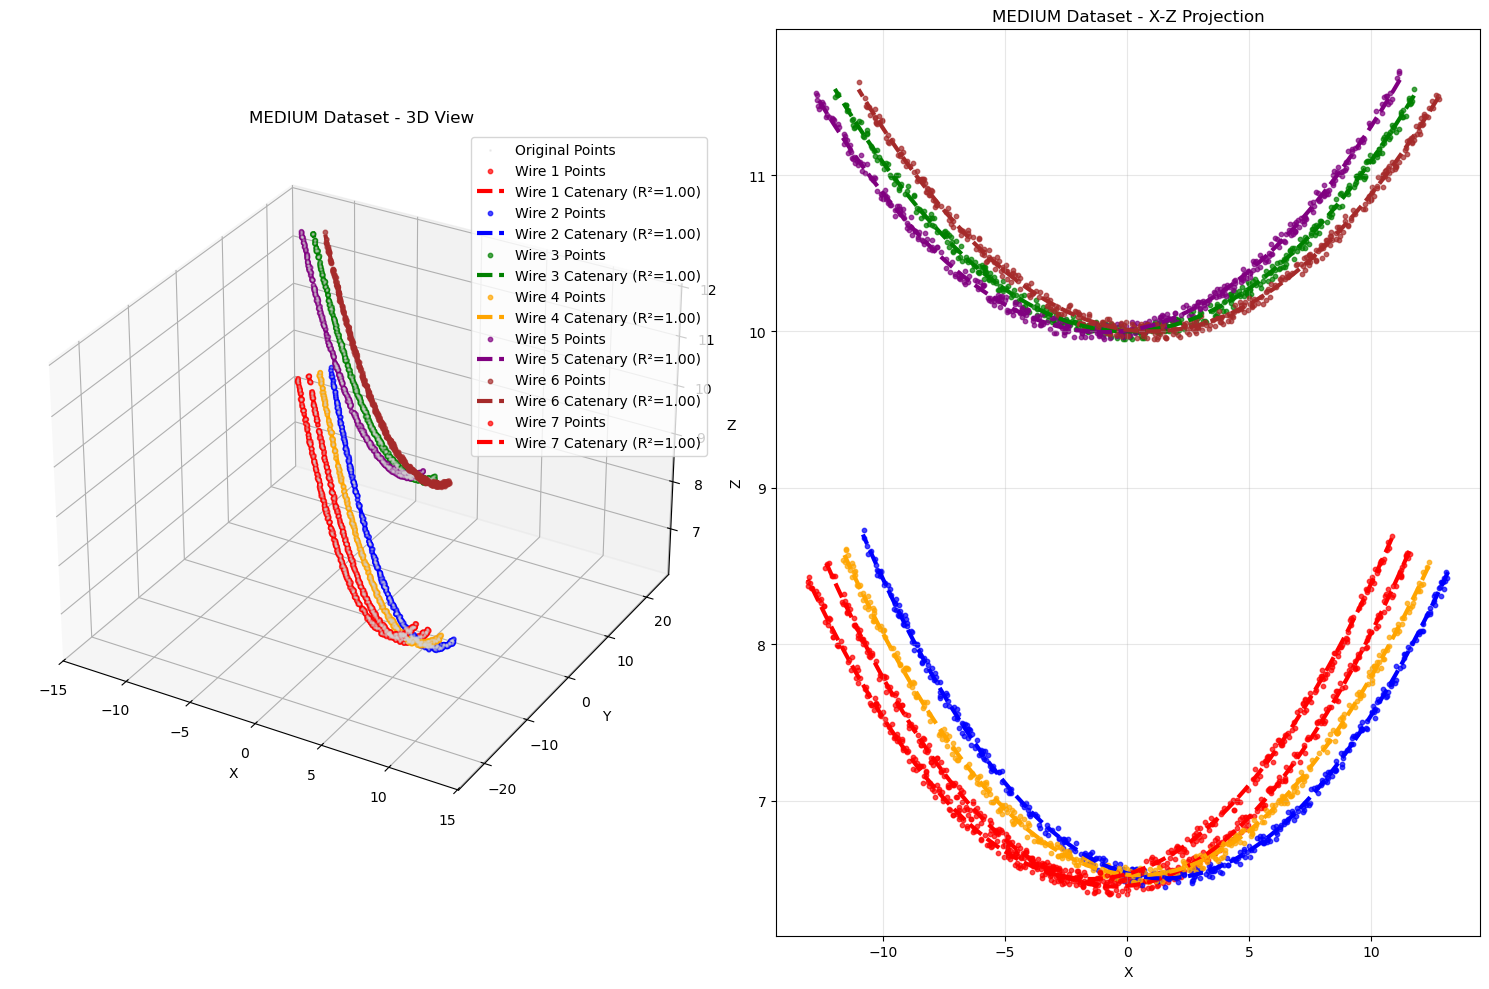


📊 SUMMARY for 'MEDIUM':
  Wire 1: a=148.107, x0=-0.228, y0=-148.818, R²=0.998
  Wire 2: a=151.066, x0=0.318, y0=-151.790, R²=0.998
  Wire 3: a=201.082, x0=0.379, y0=-201.568, R²=0.996
  Wire 4: a=155.659, x0=0.252, y0=-156.335, R²=0.998
  Wire 5: a=199.925, x0=0.259, y0=-200.441, R²=0.996
  Wire 6: a=202.452, x0=0.331, y0=-202.955, R²=0.996
  Wire 7: a=152.801, x0=-0.933, y0=-153.516, R²=0.998

🔍 ANALYZING 'HARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.70 degrees.
--- Applying Strategy 3: Corrected Hough Transform ---
✅ Found 3 wire clusters

--- Fitting Catenary Curves for HARD ---
  Processing Wire 1: 214 points
    ✅ Wire 1: a=197.451, x0=1.187, y0=-197.954, R²=0.995
  Processing Wire 2: 209 points
    ✅ Wire 2: a=200.584, x0=-0.034, y0=-201.106, R²=0.996
  Processing Wire 3: 178 points
    ✅ Wire 3: a=201.677, x0=0.375, y0=-202.215, R²=0.996


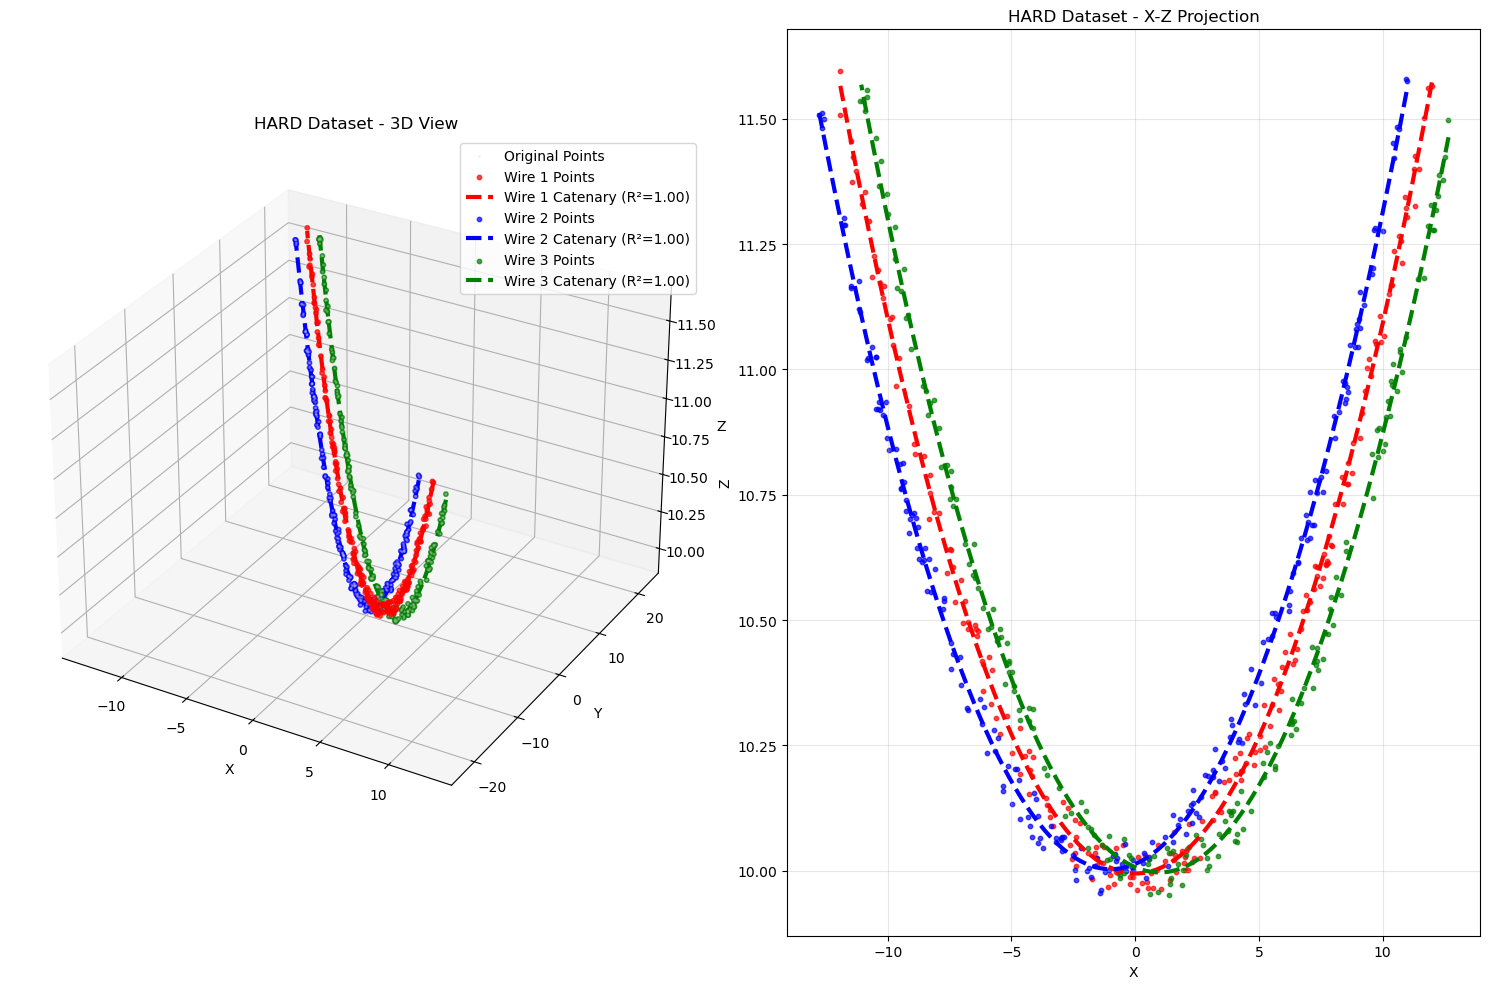


📊 SUMMARY for 'HARD':
  Wire 1: a=197.451, x0=1.187, y0=-197.954, R²=0.995
  Wire 2: a=200.584, x0=-0.034, y0=-201.106, R²=0.996
  Wire 3: a=201.677, x0=0.375, y0=-202.215, R²=0.996

🔍 ANALYZING 'EXTRAHARD' DATASET
  - Aligning point cloud...
  - Cloud rotated by -118.64 degrees.
--- Applying Strategy 2: Global DBSCAN (eps=0.8, min_samples=15) ---
✅ Found 3 wire clusters

--- Fitting Catenary Curves for EXTRAHARD ---
  Processing Wire 1: 387 points
    ✅ Wire 1: a=200.097, x0=0.286, y0=-200.608, R²=0.996
  Processing Wire 2: 397 points
    ✅ Wire 2: a=202.372, x0=-0.045, y0=-202.881, R²=0.996
  Processing Wire 3: 417 points
    ✅ Wire 3: a=200.782, x0=0.376, y0=-201.267, R²=0.996


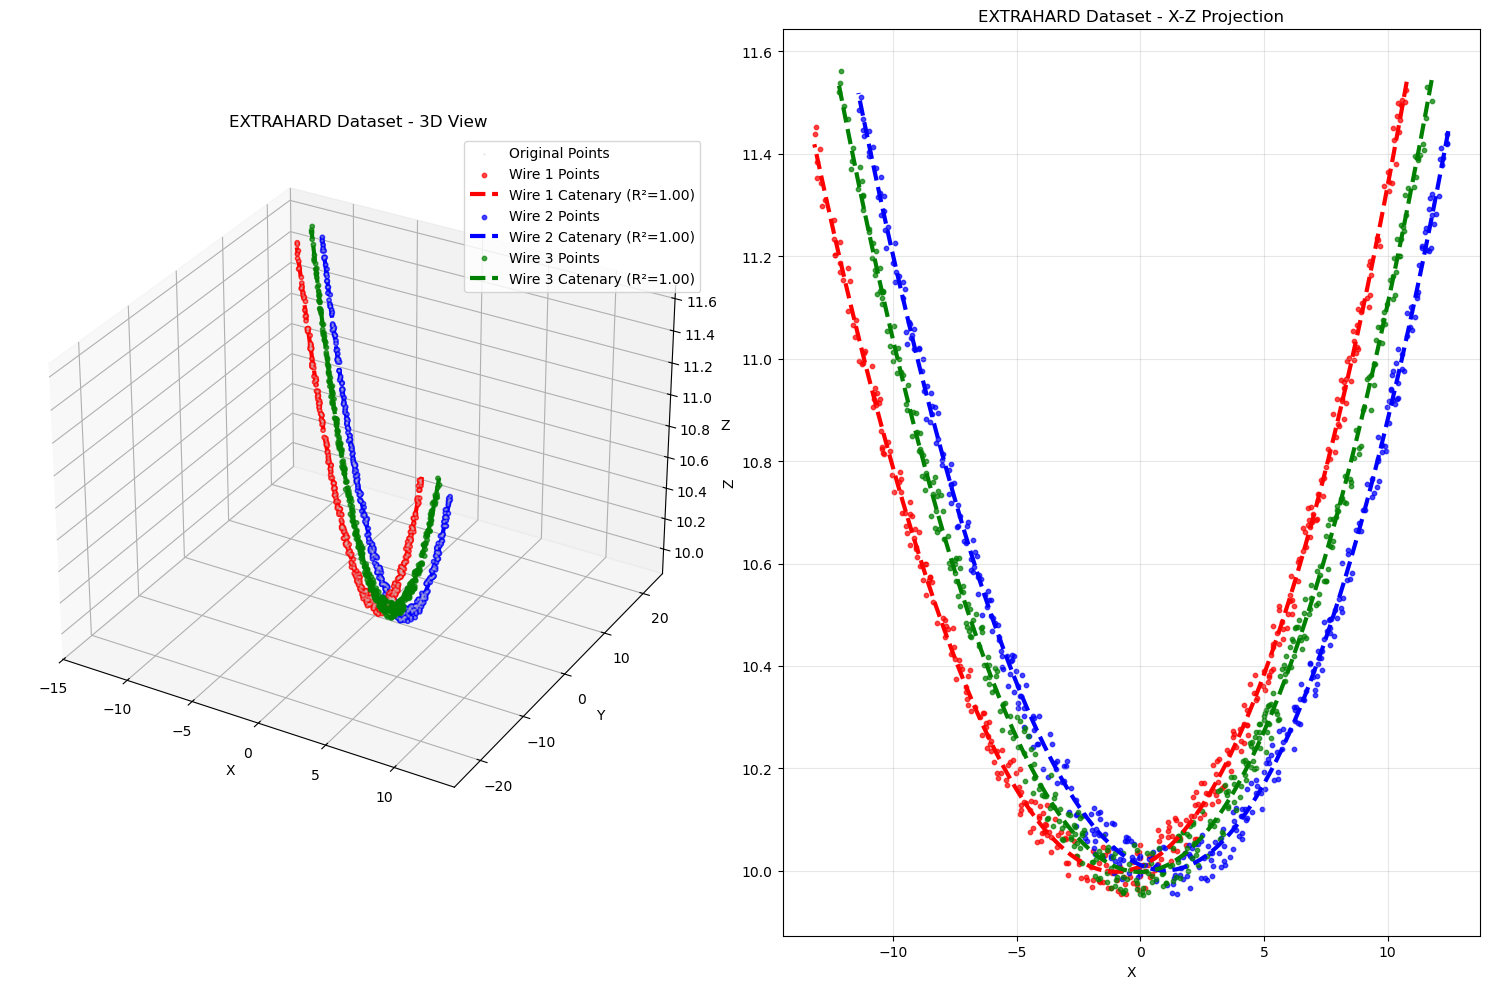


📊 SUMMARY for 'EXTRAHARD':
  Wire 1: a=200.097, x0=0.286, y0=-200.608, R²=0.996
  Wire 2: a=202.372, x0=-0.045, y0=-202.881, R²=0.996
  Wire 3: a=200.782, x0=0.376, y0=-201.267, R²=0.996


In [31]:
results = run_complete_analysis_with_catenary()